In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib. pyplot as plt
from tqdm import trange
import math

In [2]:
# ================================================================
# Coordinate → Fourier features
# ================================================================
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim=2, mapping_size=64, scale=10.0):
        super().__init__()
        self.register_buffer('B', torch.randn(input_dim, mapping_size) * scale)

    def forward(self, coords):                               # (B,H,W,2)
        proj = 2 * math.pi * torch.matmul(coords, self.B)    # (B,H,W,mapping_size)
        ff   = torch.cat([torch.cos(proj), torch.sin(proj)], dim=-1)
        return ff.permute(0, 3, 1, 2)                        # (B,2*mapping_size,H,W)

# ---------------------------------------------------------------
def get_coord_grid(batch, h, w, device):
    xs = torch.linspace(0, 1, w, device=device)
    ys = torch.linspace(0, 1, h, device=device)
    gy, gx = torch.meshgrid(ys, xs, indexing='ij')
    grid = torch.stack((gx, gy), dim=-1).unsqueeze(0).repeat(batch, 1, 1, 1)
    return grid                                              # (B,H,W,2)

# ================================================================
# Fourier Neural Operator 2-D spectral layer
# ================================================================
class FourierLayer(nn.Module):
    def __init__(self, in_ch, out_ch, modes1, modes2):
        super().__init__()
        self.modes1, self.modes2 = modes1, modes2
        self.weight = nn.Parameter(
            torch.randn(in_ch, out_ch, modes1, modes2, dtype=torch.cfloat)
            / (in_ch * out_ch)
        )

    @staticmethod
    def compl_mul2d(inp, w):                                 # (B,IC,H,W) × (IC,OC,H,W)
        return torch.einsum('bixy,ioxy->boxy', inp, w)

    def forward(self, x):                                    # (B,C,H,W)  real
        B, _, H, W = x.shape
        x_ft = torch.fft.rfft2(x)

        m1 = min(self.modes1, H)
        m2 = min(self.modes2, x_ft.size(-1))                 # W_freq = W//2+1

        out_ft = torch.zeros(
            B, self.weight.size(1), H, x_ft.size(-1),
            dtype=torch.cfloat, device=x.device
        )
        out_ft[:, :, :m1, :m2] = self.compl_mul2d(
            x_ft[:, :, :m1, :m2],
            self.weight[:, :, :m1, :m2]
        )
        return torch.fft.irfft2(out_ft, s=x.shape[-2:])

# ---------------------------------------------------------------
class ConvBlock(nn.Module):
    """[Conv → GELU] × 2 (keeps H×W)."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GELU()
        )
    def forward(self, x): return self.block(x)

# ================================================================
# ↓↓↓ PixelShuffle-based up-sample block ↓↓↓
# ================================================================
class PixelShuffleUpsample(nn.Module):
    def __init__(self, in_ch, out_ch, upscale=2):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * (upscale ** 2), 3, padding=1)
        self.pix  = nn.PixelShuffle(upscale)
        self.act  = nn.GELU()
    def forward(self, x):
        return self.act(self.pix(self.conv(x)))

# ================================================================
# U-Net with Fourier bottleneck + PixelShuffle up-sampling
# NOTE: -- No pooling inside the bottleneck (only in encoder) --
# ================================================================
class SuperResUNet(nn.Module):
    def __init__(
        self,
        in_channels=11,
        lift_dim=128,
        mapping_size=64,
        mapping_scale=5.0,
        final_scale=2        # ← auto-detected from data
    ):
        super().__init__()

        # -------- lift ---------------
        self.fourier_mapping = FourierFeatureMapping(2, mapping_size, mapping_scale)
        lifted_ch = in_channels + 2 * mapping_size
        self.lift = nn.Conv2d(lifted_ch, lift_dim, kernel_size=1)

        # -------- encoder ------------
        self.enc1 = ConvBlock(lift_dim,        lift_dim)        # keep  (Hc)
        self.enc2 = ConvBlock(lift_dim,        lift_dim * 2)    # pool → (Hc/2)
        self.pool = nn.MaxPool2d(2)

        # -------- bottleneck ---------
    
        self.bottleneck = nn.Sequential(
            ConvBlock(lift_dim * 2, lift_dim * 2),
            FourierLayer(lift_dim * 2, lift_dim * 2, modes1=32, modes2=32),
            nn.GELU()
        )

        # -------- decoder ------------
        # up1 keeps spatial dims (upscale=1) so it matches e2
        self.up1  = PixelShuffleUpsample(lift_dim * 2, lift_dim * 2, upscale=1)
        self.dec2 = ConvBlock(lift_dim * 4, lift_dim)                    # cat(up1,e2)

        self.up2  = PixelShuffleUpsample(lift_dim, lift_dim)             # ×2  (Hc/2 → Hc)
        self.dec1 = ConvBlock(lift_dim * 2, lift_dim // 2)               # cat(up2,e1)

        self.dec0 = nn.Sequential(                                       # Hc → Hc×final_scale
            PixelShuffleUpsample(lift_dim // 2, lift_dim // 4, upscale=final_scale),
            ConvBlock(lift_dim // 4, lift_dim // 4)
        )

        # -------- output head --------
        self.out_head = nn.Sequential(
            nn.Conv2d(lift_dim // 4, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, in_channels, 3, padding=1)                      # 11-channel output
        )

    # -----------------------------------------------------------
    def forward(self, x):                                 # (B,11,Hc,Wc) normalised
        B, _, H, W = x.shape
        coords = get_coord_grid(B, H, W, x.device)
        x = torch.cat([x, self.fourier_mapping(coords)], dim=1)   # lift
        x = self.lift(x)

        e1 = self.enc1(x)               # Hc
        e2 = self.enc2(self.pool(e1))   # Hc/2

        # ---- bottleneck ----
        b  = self.bottleneck(e2)        # Hc/2

        # ---- decoder ----
        d2 = self.up1(b)                             # Hc/2  (spatially matches e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up2(d2)                            # Hc
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        d0 = self.dec0(d1)                           # Hf
        return self.out_head(d0)                     # (B,11,Hf,Wf)  normalised

In [3]:
# Data Loader: Load full trajectory (20 time steps) for evaluation
# ----------------------------
def load_single_sample_full(idx=0):
    input_CG = np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_coarse_64_test_data.npy')[:, :]
    target_FG =  np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_fine_128_test_data.npy')[:, :]
    # Convert to PyTorch tensors
    input_tensor = torch.tensor(input_CG, dtype=torch.float32)
    target_tensor = torch.tensor(target_FG, dtype=torch.float32)
    return input_tensor[idx], target_tensor[idx]

In [4]:
# ----------------------------
# Evaluation: Iterative Future Extrapolation with AB3 on the Coarse Grid
# ----------------------------

device = 'cpu'#torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Initialize models and load saved weights
model = SuperResUNet(final_scale=4).to(device)
model.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/2d_vlasov_FUnet_best_PS_new.pth'))
model.eval()

SuperResUNet(
  (fourier_mapping): FourierFeatureMapping()
  (lift): Conv2d(139, 128, kernel_size=(1, 1), stride=(1, 1))
  (enc1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
    )
  )
  (enc2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GELU(approximate='none')
        (2): Conv2d(256, 256

In [5]:
# # Load full trajectory sample 
# idx = 0
# input_data, output_data = load_single_sample_full(idx)
input_CG = np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_coarse_32_test_data.npy')[:, :]
target_FG =  np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_fine_128_test_data.npy')[:, :]
input_data, output_data = torch.tensor(input_CG), torch.tensor(target_FG)
input_data.shape, output_data.shape

(torch.Size([100, 11, 32, 32]), torch.Size([100, 11, 128, 128]))

In [6]:
# Normalize stats
stats = torch.load('./data/2d_vlasov_funet_phase1_stats.pt', map_location=device)
data_mean = stats['data_mean'].squeeze(0)
data_std  = stats['data_std'].squeeze(0)

In [7]:
with torch.no_grad():
    pred = model((input_data.float().to(device)  - data_mean) / data_std).squeeze(0)
    pred  = pred * data_std + data_mean

In [8]:
pred = pred.cpu().detach()

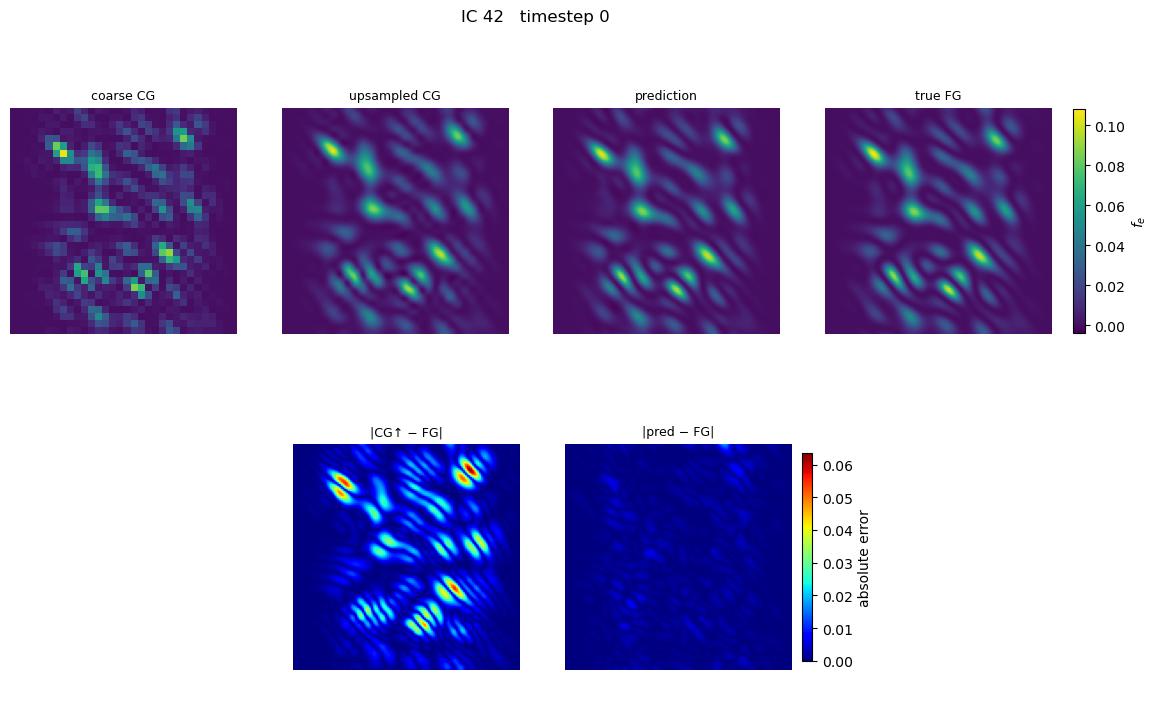

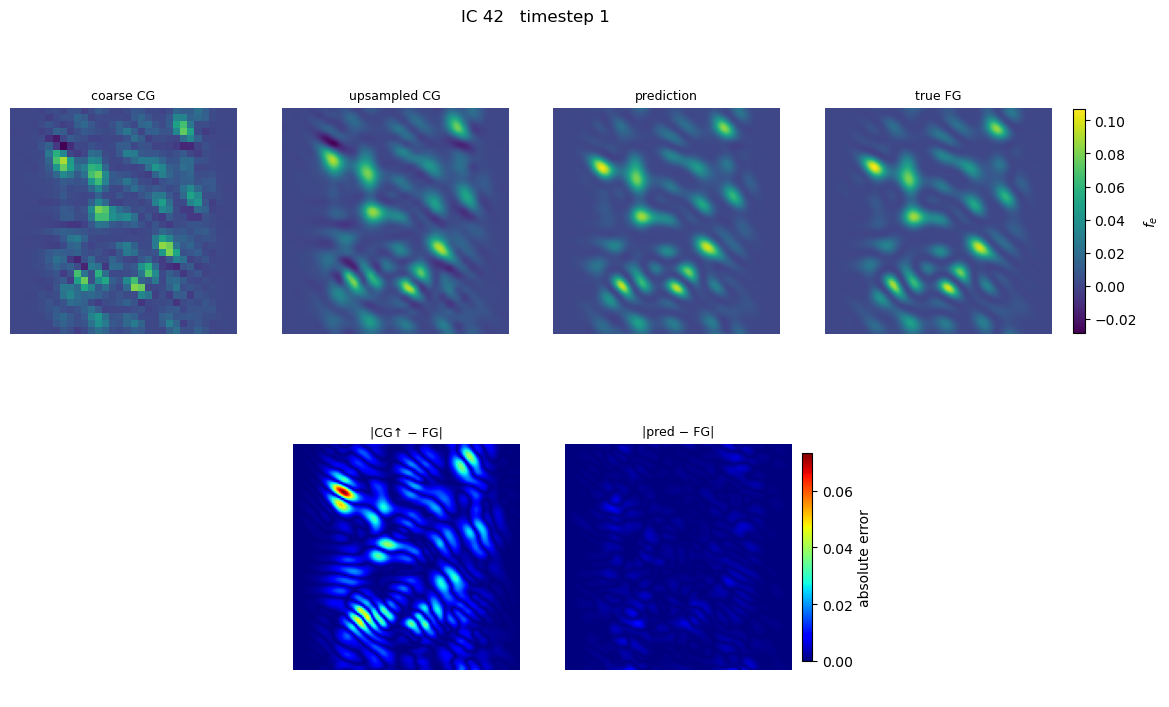

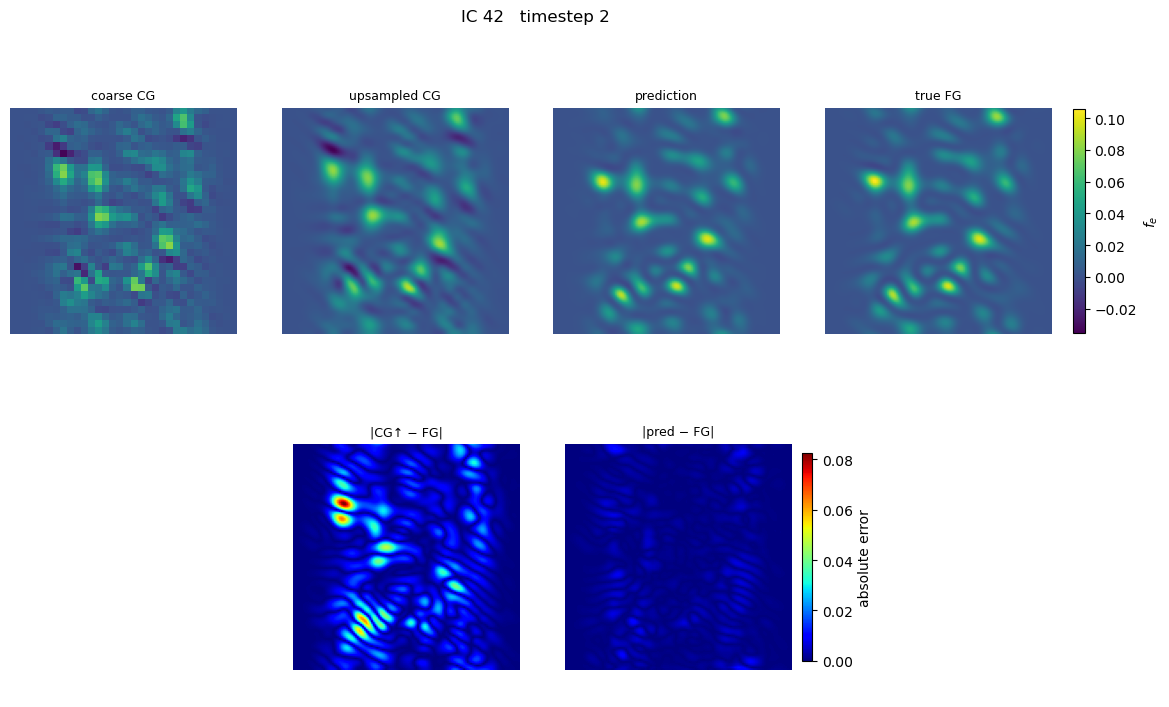

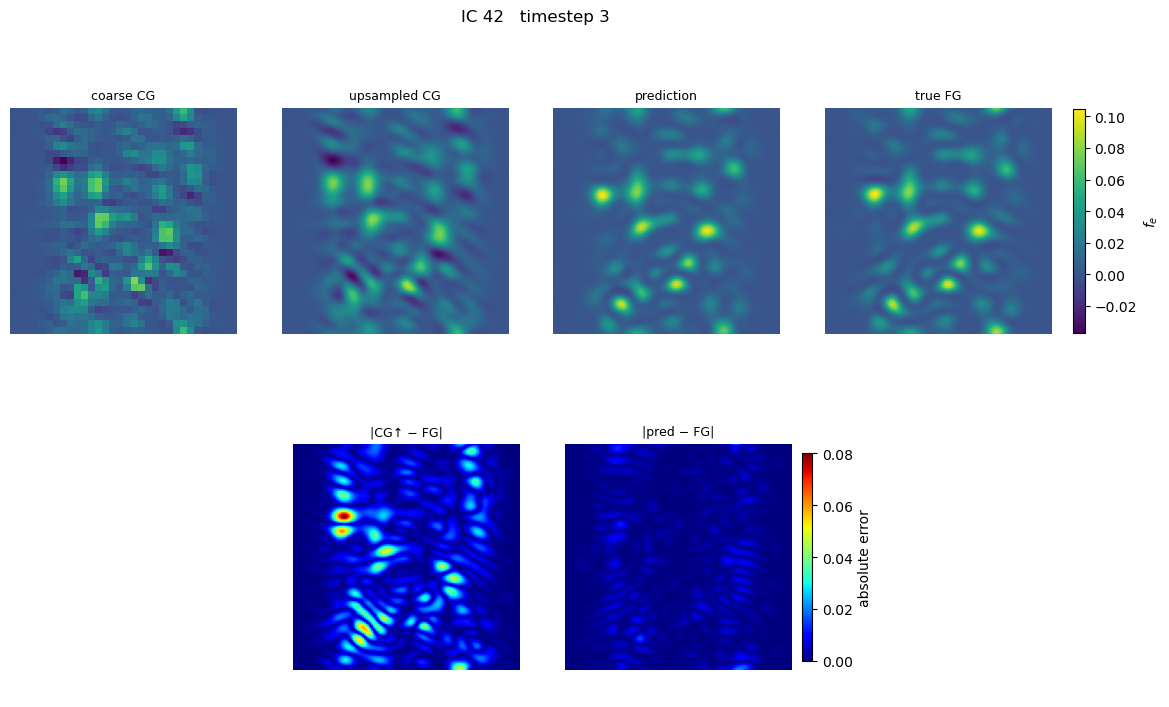

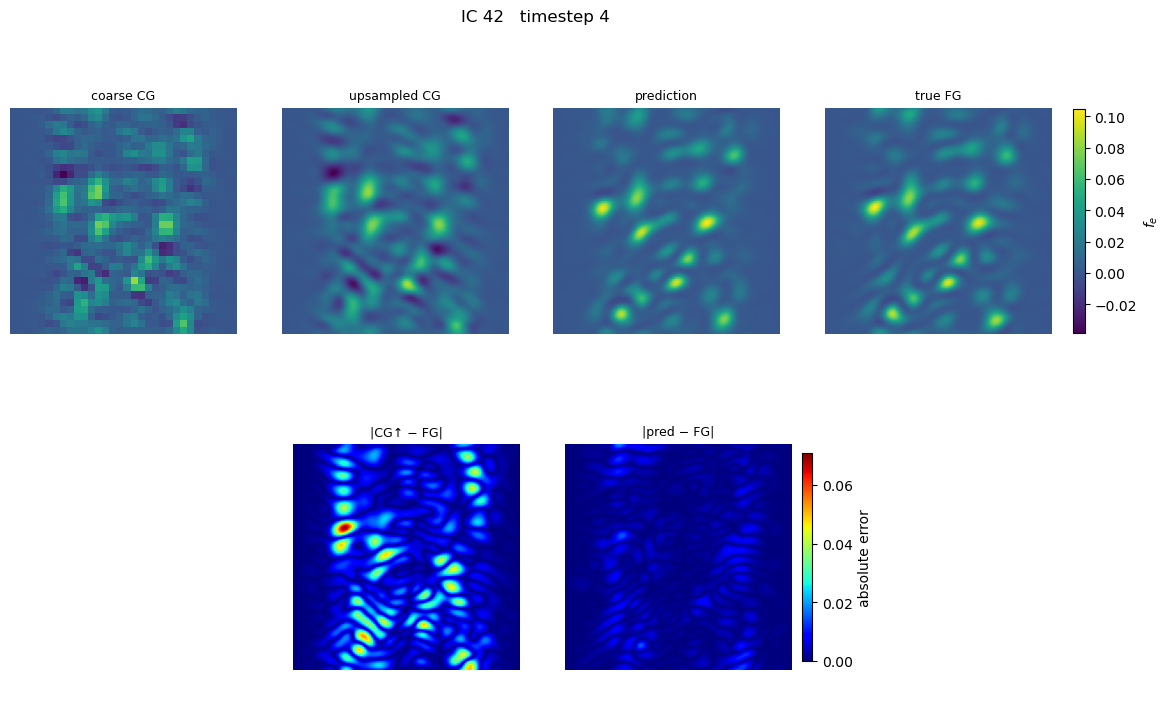

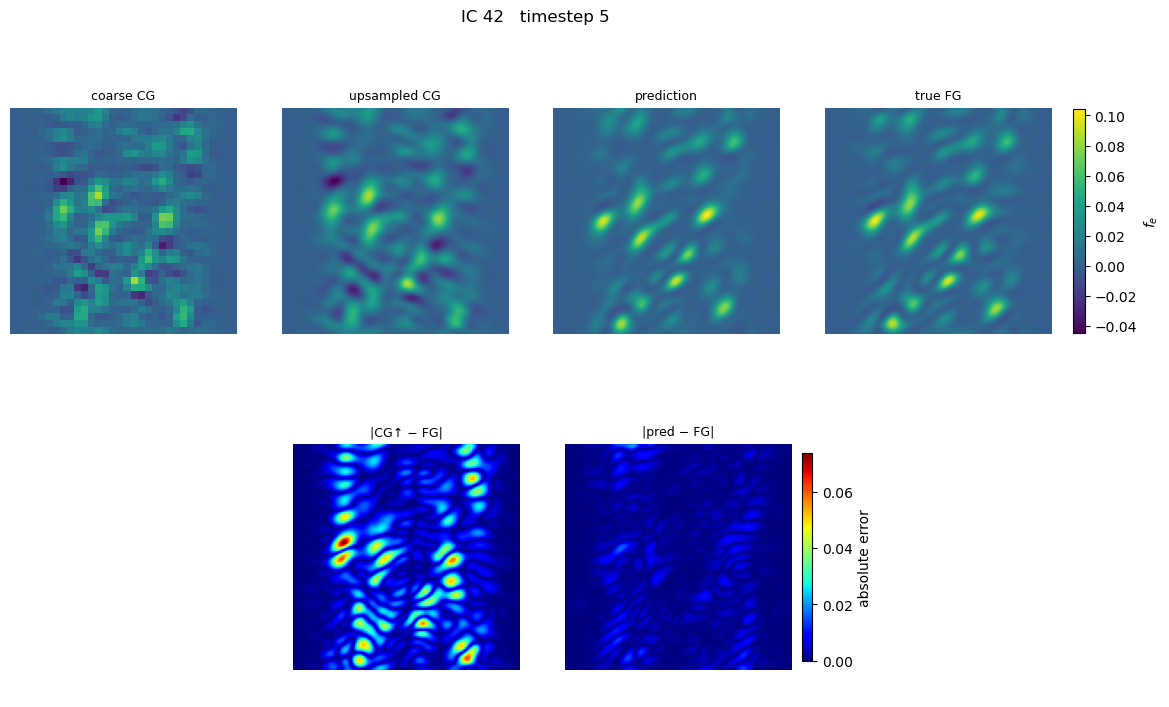

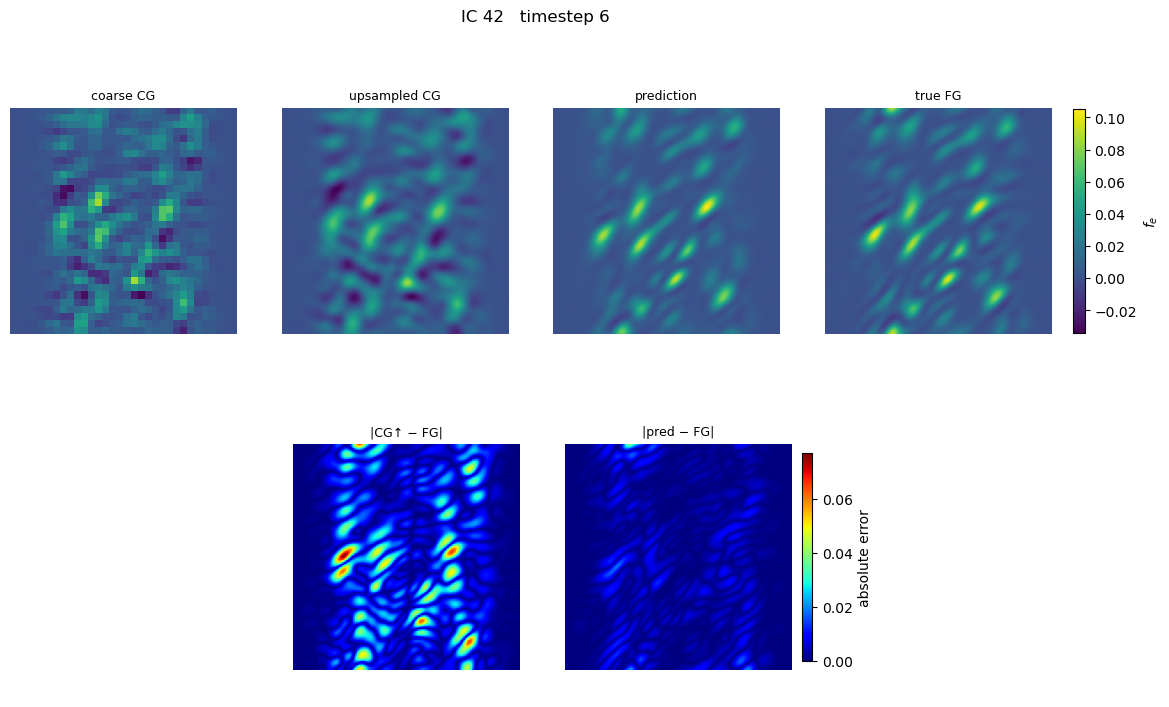

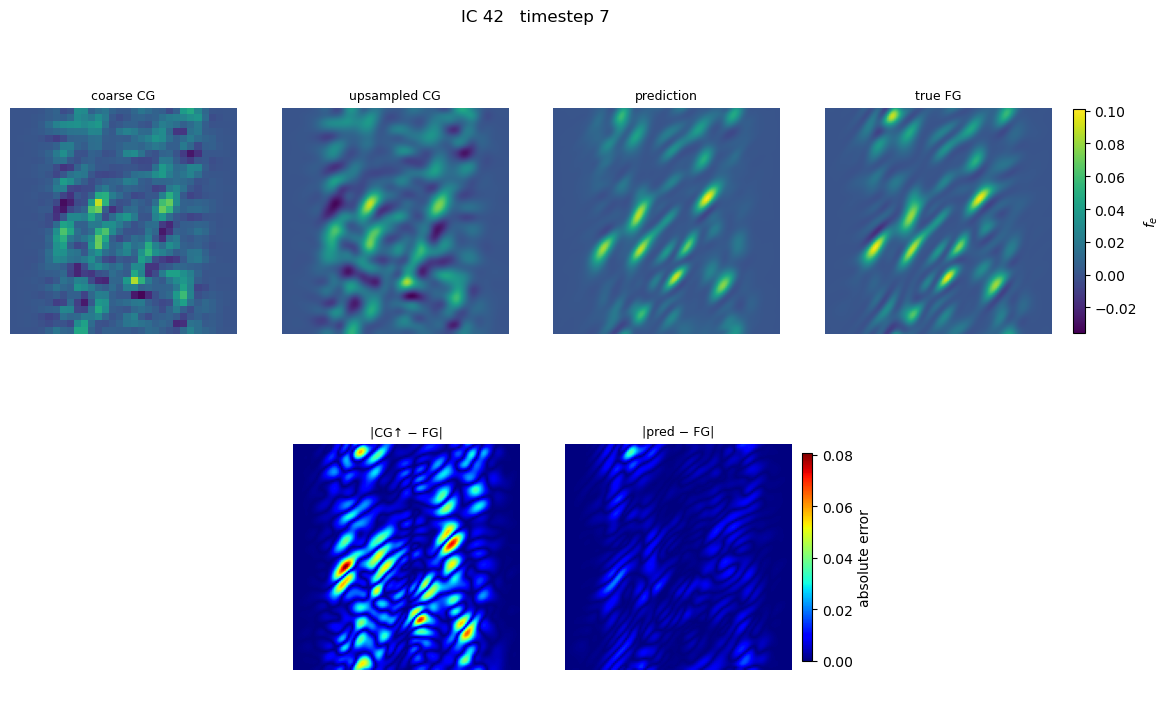

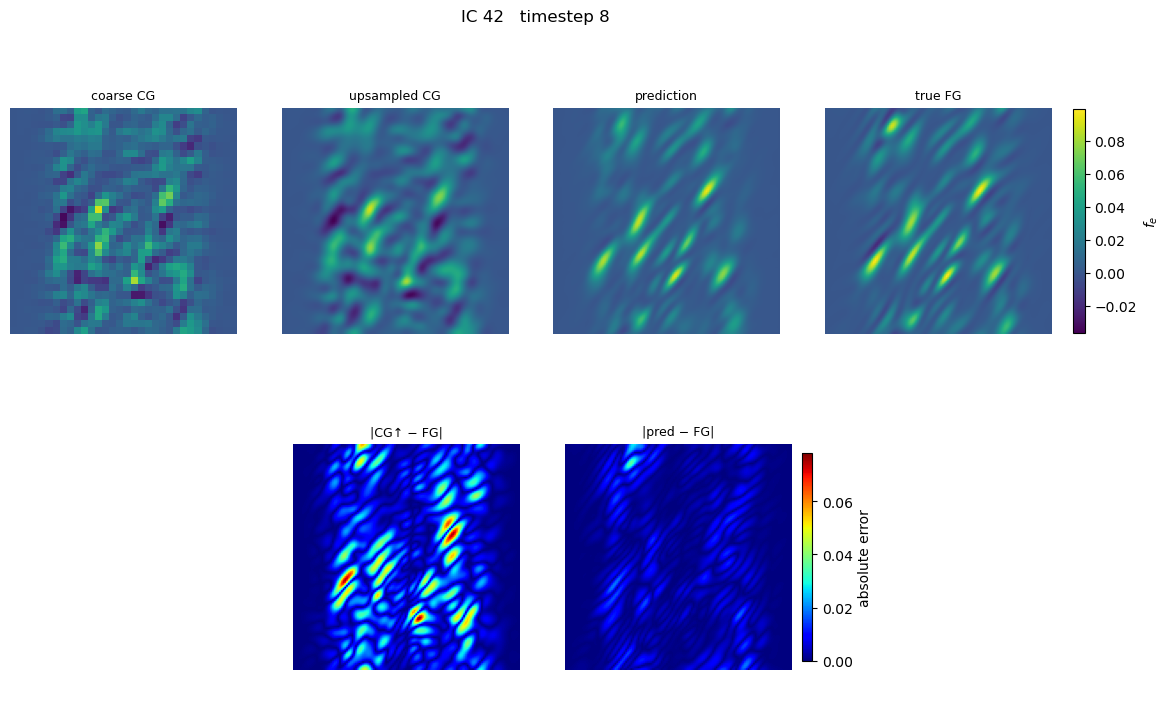

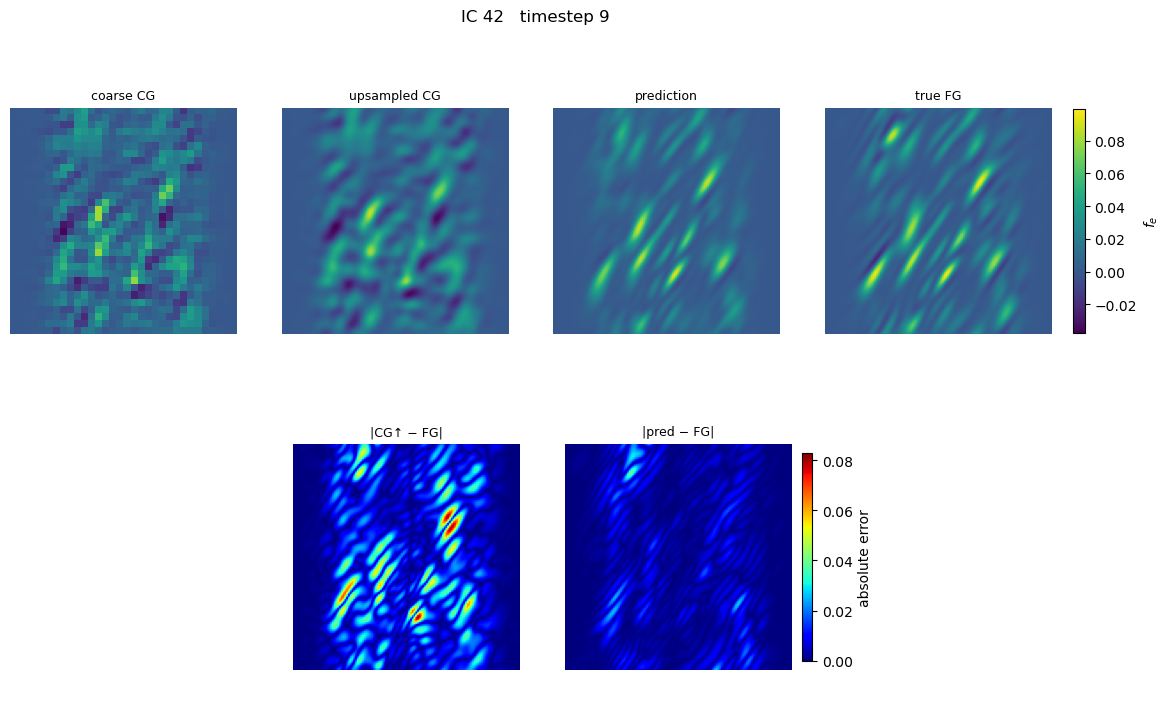

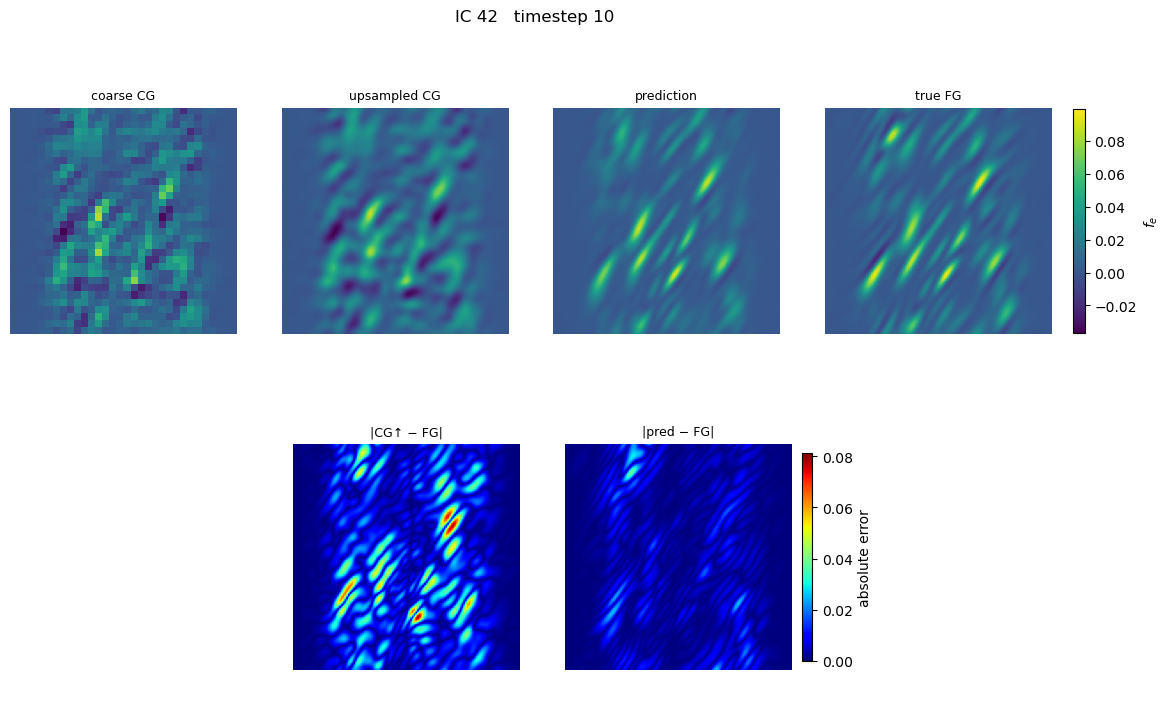

In [22]:
from scipy.ndimage import zoom
# ---------- automatic sizes ----------
N, Nt, Nc, _ = input_data.shape     # (N, Nt, 128, 128)
Nf           = output_data.shape[2] # 256
scale        = Nf / Nc              # 2.0

case_list = [42]                   # choose any trajectory indices

for case in case_list:
    for t in range(Nt):

        # --- data & up‑sampling -----------------------------------------
        rho_cg   = input_data [case, t]                  # 128×128
        rho_up   = zoom(rho_cg, scale, order=3)          # 256×256
        rho_pred = pred        [case, t]                 # 256×256
        rho_fine = output_data[case, t]                  # 256×256

        # --- common scale for the first‑row images ----------------------
        vmin = np.min([rho_cg.min(), rho_up.min(),
                       rho_pred.min(), rho_fine.min()])
        vmax = np.max([rho_cg.max(), rho_up.max(),
                       rho_pred.max(), rho_fine.max()])

        # --- error maps & common scale ----------------------------------
        err_up   = np.abs(rho_up   - rho_fine.cpu().detach().numpy())
        err_pred = np.abs(rho_pred - rho_fine.cpu().detach().numpy())
        err_max  = max(err_up.max(), err_pred.max())

        # --- figure with 2 rows ----------------------------------------
        fig, axes = plt.subplots(2, 4, figsize=(14, 8),
                                 gridspec_kw={'height_ratios': [1, 1]},
                                 sharex=False, sharey=False)

        # -------- first row: fields -------------------------------------
        panels = [rho_cg, rho_up, rho_pred, rho_fine]
        titles = ["coarse CG", "upsampled CG",
                  "prediction", "true FG"]
        for ax, im, ttl in zip(axes[0], panels, titles):
            h = ax.imshow(im, origin='lower', vmin=vmin, vmax=vmax)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')

        fig.colorbar(h, ax=axes[0, :], orientation='vertical',
                     fraction=0.02, pad=0.02, shrink=0.8,
                     label=r"$f_e$")

        # -------- second row: absolute errors ---------------------------
        err_axes = [axes[1, 1], axes[1, 2]]          # centre two cells
        err_imgs = [err_up, err_pred]
        err_ttl  = ["|CG↑ − FG|", "|pred − FG|"]
        for ax, im, ttl in zip(err_axes, err_imgs, err_ttl):
            h_err = ax.imshow(im, origin='lower', cmap='jet',
                              vmin=0, vmax=err_max)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')

        # blank the unused corners
        axes[1, 0].axis('off')
        axes[1, 3].axis('off')

        fig.colorbar(h_err, ax=err_axes, orientation='vertical',
                     fraction=0.02, pad=0.02, shrink=0.8,
                     label='absolute error')

        fig.suptitle(f"IC {case}   timestep {t}", y=0.97, fontsize=12)
        #plt.tight_layout()
        plt.savefig(f'./figures/new_vlasov/funet/flow/funet_phase1_test_fe_ic={case}_t={t}.png')
        plt.show()

In [11]:
# -------------- constants & quick sizes ----------
qe          = -1.0
dv          = {32: 0.375,        # coarse grid
               128: 0.09375}          # fine   grid

N, Nt, Nc, _ = input_data.shape     # Nc = 128
Nf           = output_data.shape[2] # 256
scale_x      = Nf / Nc              # 2.0  for 128→256

In [13]:
rho_cg_up.shape

(128, 128)

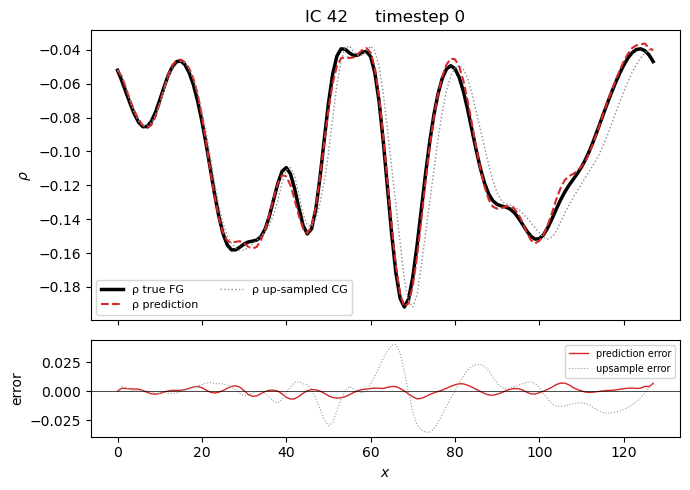

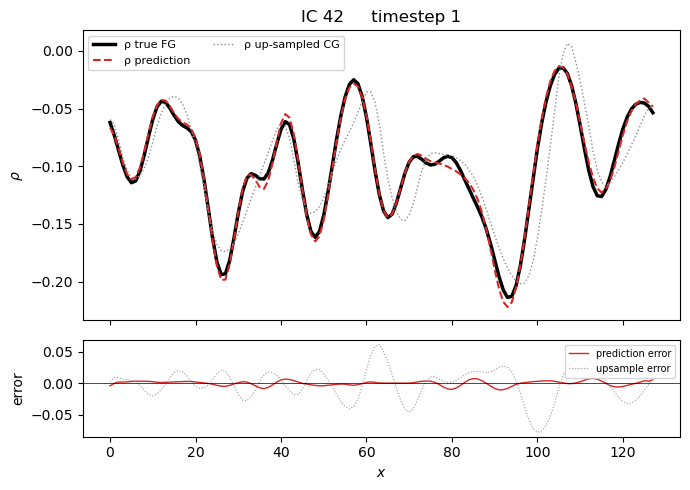

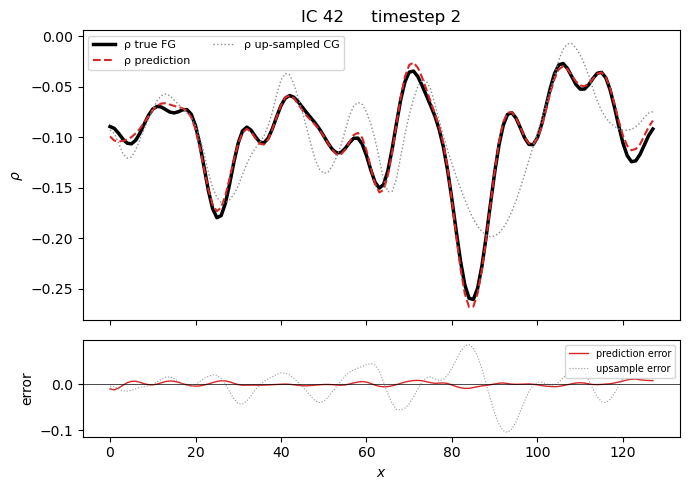

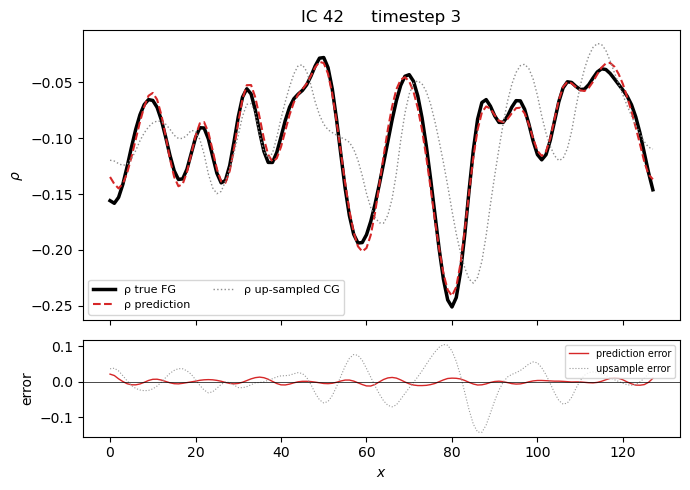

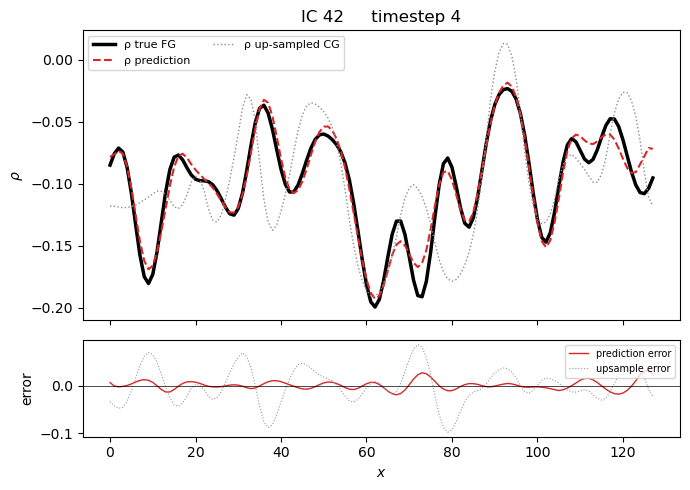

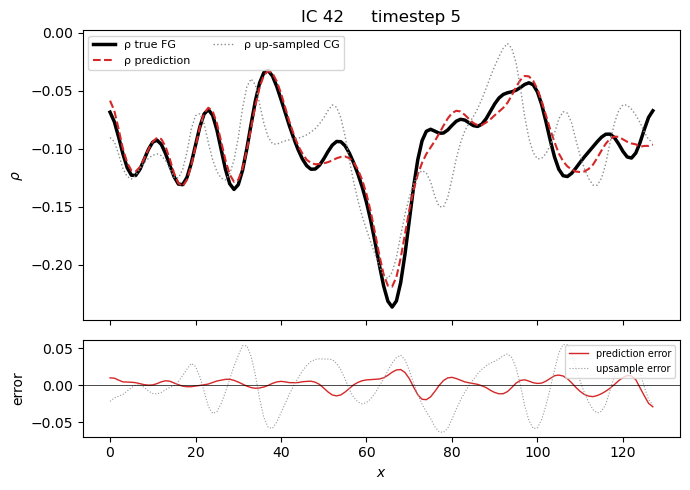

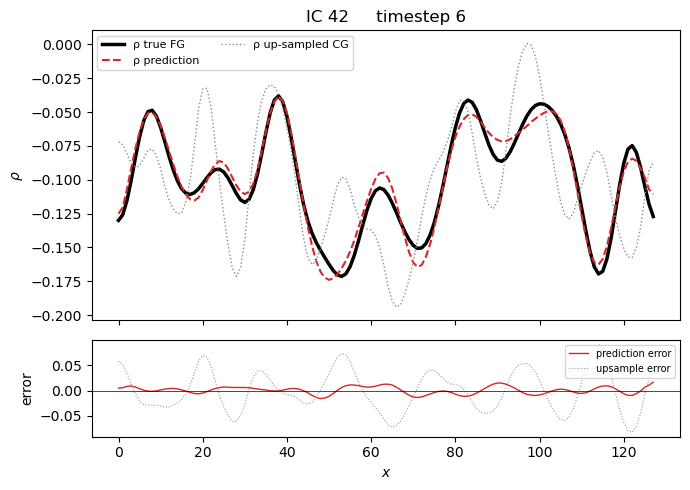

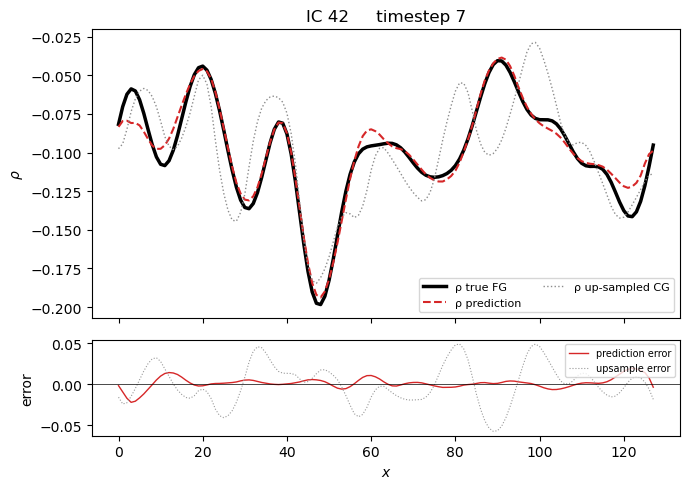

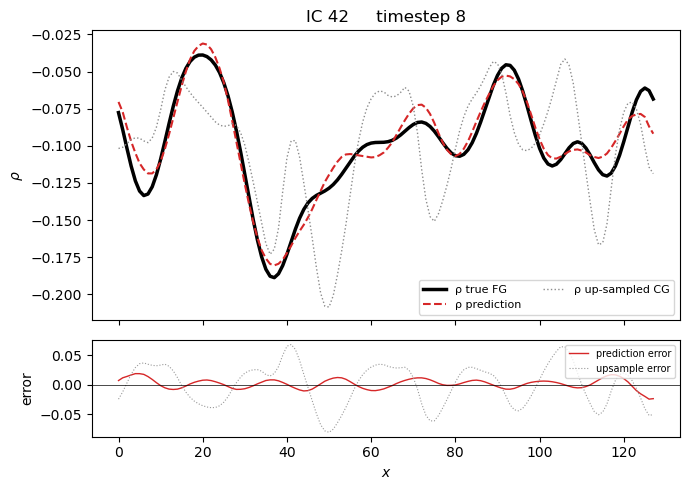

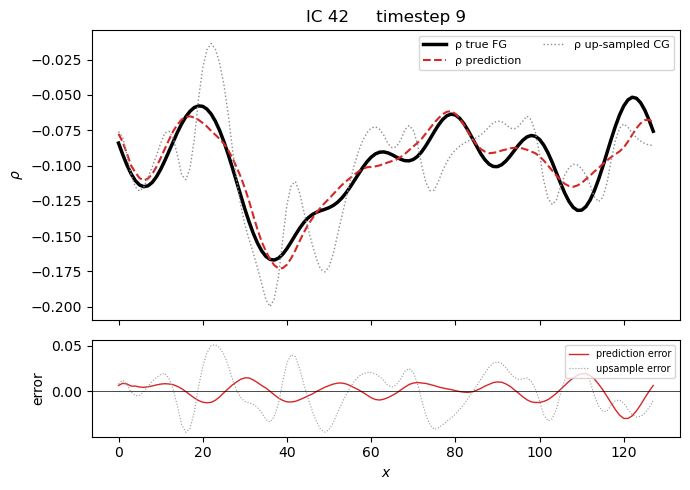

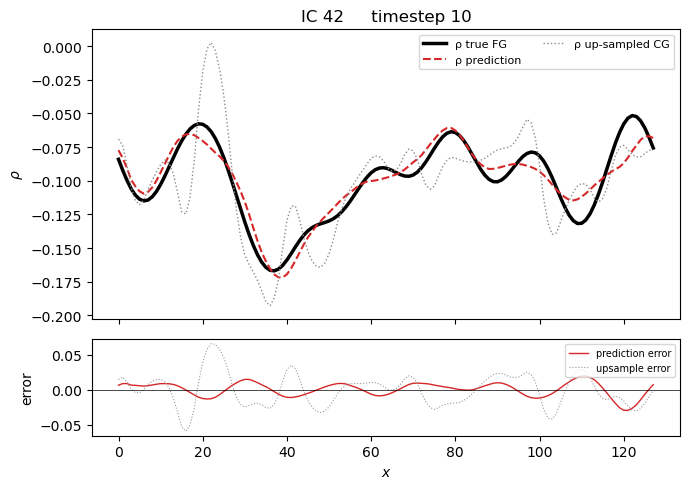

In [14]:
case_list    = [42]                 # or range(0, N, 10)

# -------------------------------------------------

for case in case_list:
    for t in range(Nt):

        # -------- phase‑space → charge density ρ(x) --------
        # sum over velocity (last axis) and scale by Δv
        rho_cg   = qe * input_data[case, t].sum(axis=-1) * dv[Nc]   # (128,)
        rho_fine = qe * output_data[case, t].sum(axis=-1) * dv[Nf]   # (256,)
        rho_pred = qe * pred       [case, t].sum(axis=-1) * dv[Nf]   # (256,)
        rho_fine = rho_fine.cpu().detach().numpy()
        rho_cg_up = zoom(rho_cg, zoom=scale_x, order=2)              
        #print(rho_cg.shape, rho_fine.shape, rho_pred.shape, rho_cg_up.shape)
        # ----------- shared x‑axis grids -----------
        x_cg   = np.arange(Nc)
        x_fine = np.linspace(0, Nf-1, Nf)

        # -------------- plotting ------------------
        # ----- main figure with residual subplot -----
        fig, (ax, axr) = plt.subplots(2, 1, figsize=(7, 5),
                                      gridspec_kw=dict(height_ratios=[3, 1]),
                                      sharex=True)
        
        # top: densities ------------------------------------------------------
        ax.plot(x_fine, rho_fine,  color='k',   lw=2.5, label='ρ true FG')
        ax.plot(x_fine, rho_pred,  color='C3',  lw=1.5, ls='--', label='ρ prediction')
        ax.plot(x_fine, rho_cg_up, color='0.55', ls=':', lw=1,  label='ρ up‑sampled CG')
        #ax.plot(x_cg,   rho_cg,    color='0.75', lw=.8,  marker='o', ms=3,
          #      label='ρ coarse CG')
        
        ax.set_ylabel(r"$\rho$")
        ax.legend(fontsize=8, ncol=2)
        ax.set_title(f"IC {case}   timestep {t}")
        
        # bottom: residuals ---------------------------------------------------
        res_p  = rho_pred  - rho_fine
        res_cg = rho_cg_up - rho_fine
        axr.plot(x_fine, res_p,  color='C3', lw=1, label='prediction error')
        axr.plot(x_fine, res_cg, color='0.6', lw=.8, ls=':', label='upsample error')
        axr.axhline(0, color='k', lw=.5)
        axr.set_xlabel(r"$x$")
        axr.set_ylabel("error")
        axr.legend(fontsize=7, loc="upper right")
        
        plt.tight_layout()
        plt.show()

In [15]:
import torch, torch.nn as nn
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# ---------------------  MODEL DEFINITION  (unchanged) ---------------------
# ... FourierFeatureMapping, get_coord_grid, FourierLayer, ConvBlock ...
# ... SuperResUNet from your last version with dec0 stage ...

# -------------------------------------------------------------------------
#  LOAD DATA  -------------------------------------------------------------
# -------------------------------------------------------------------------
input_CG   = np.load('/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_coarse_32_test_data.npy')
target_FG  = np.load('/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_fine_128_test_data.npy')

input_data  = torch.tensor(input_CG,  dtype=torch.float32)          # (N, Nt, 128,128)
output_data = torch.tensor(target_FG, dtype=torch.float32)          # (N, Nt, 256,256)

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------------------------
#  EVALUATE 5 CHECKPOINTS & COLLECT PREDICTIONS ---------------------------
# -------------------------------------------------------------------------
epochs = [1000, 1500, 2000, 2400, 3000]
#ckpt_tmpl = f'/pscratch/sd/h/hbassi/models/2d_vlasov_FUnet_ckpt_{epoch:04d}_PS.pth'

N, Nt, Nc, _ = input_data.shape    # 128
Nf           = output_data.shape[2]# 256

pred_stack = []                    # will become (n_models,N,Nt,256,256)

with torch.no_grad():
    for ep in epochs:
        model = SuperResUNet(final_scale=4).to(device)
        #state = torch.load(ckpt_tmpl.format(ep), map_location=device)
        state = torch.load(f'/pscratch/sd/h/hbassi/models/2d_vlasov_FUnet_ckpt_{ep:04d}_PS_new.pth', map_location=device)
        model.load_state_dict(state['model_state_dict'])
        model.eval()

        #data_mean = input_data.mean(dim=(0, 2, 3), keepdim=True)   # (1,11,1,1)
       # data_std  = input_data.std(dim=(0, 2, 3), keepdim=True).clamp_min(1e-8)
        pred = model((input_data.float()  - data_mean) / data_std).squeeze(0)
        pred  = pred * data_std + data_mean
        #pred = model(input_data.to(device)).cpu()    # (N,Nt,256,256)
        pred_stack.append(pred)

pred_stack = torch.stack(pred_stack)                # (5,N,Nt,256,256)
mean_pred  = pred_stack.mean(dim=0)                 # (N,Nt,256,256)
std_pred   = pred_stack.std (dim=0)                 # (N,Nt,256,256)

In [16]:
# # -------------------------------------------------------------------------
# #  CONSTANTS FOR ρ(x) -----------------------------------------------------
# # -------------------------------------------------------------------------
# qe   = -1.0
# dv   = {128: 0.469*2, 256: 0.469}
# scale_x = Nf / Nc                                     # 2.0

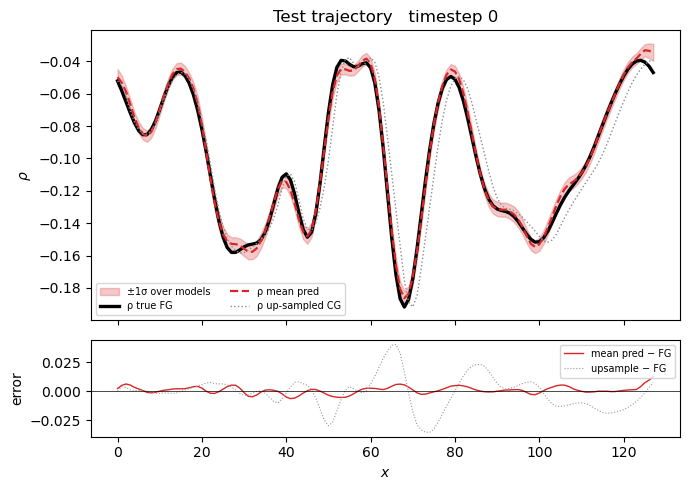

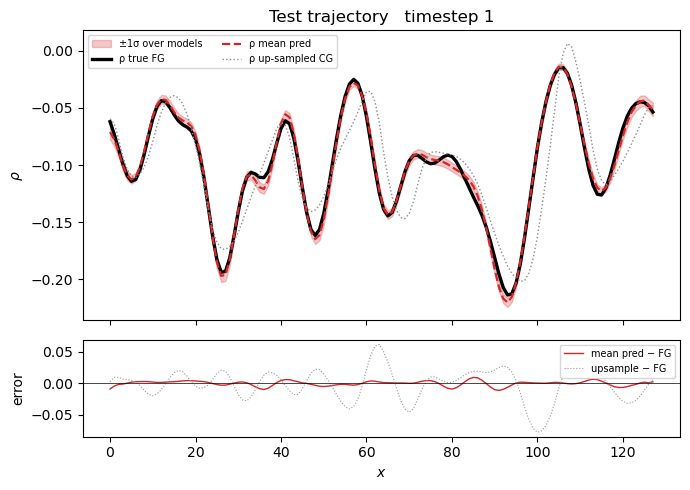

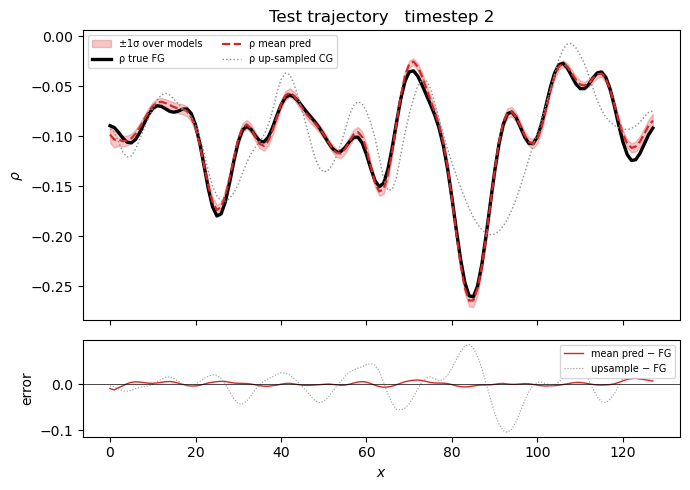

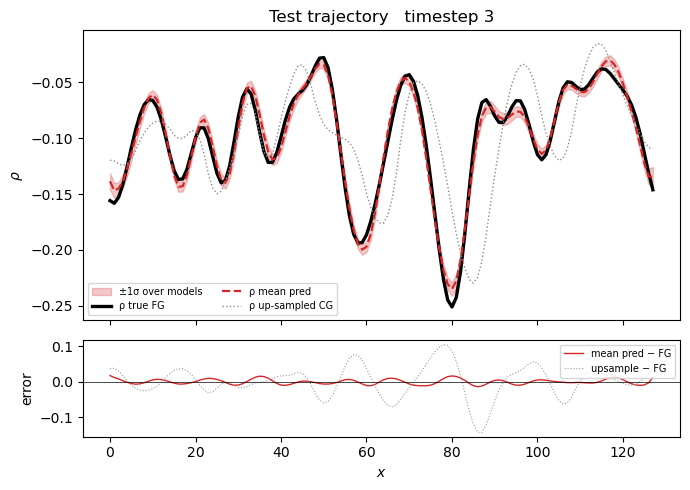

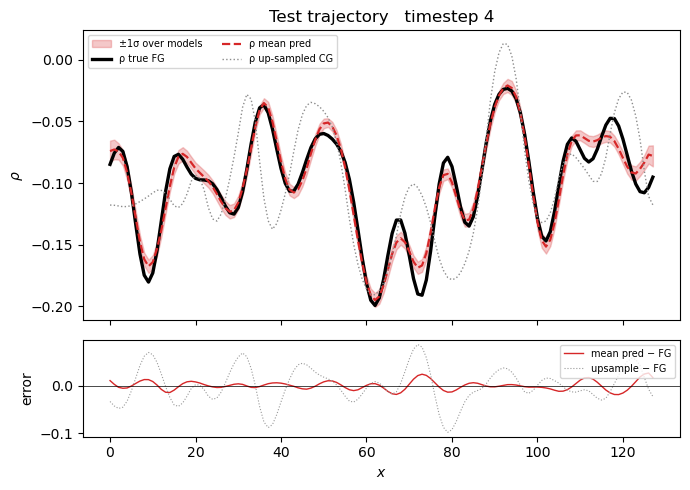

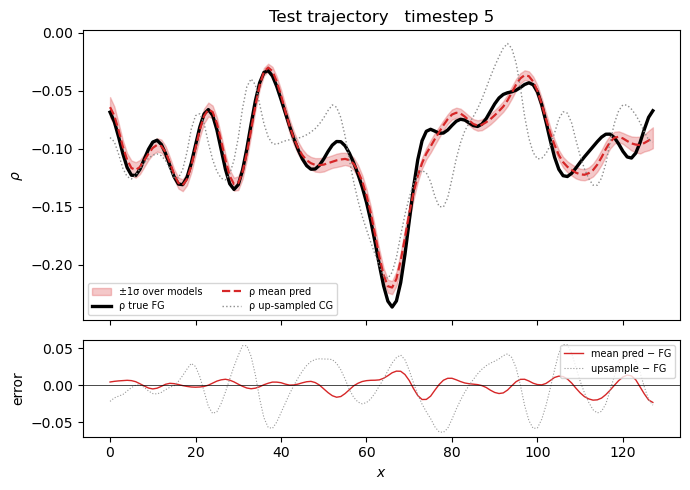

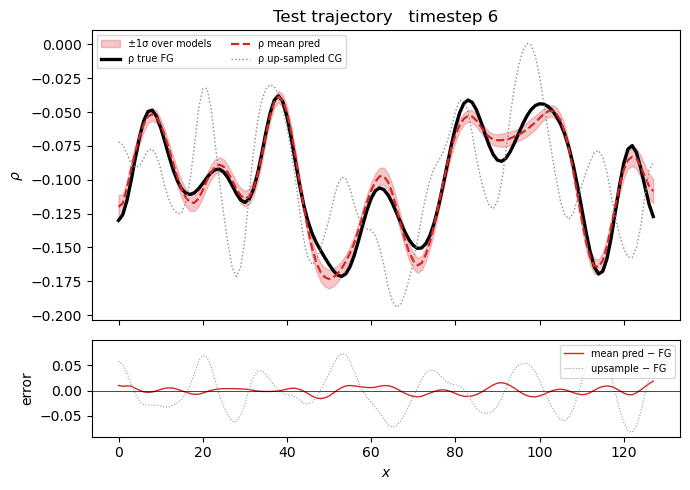

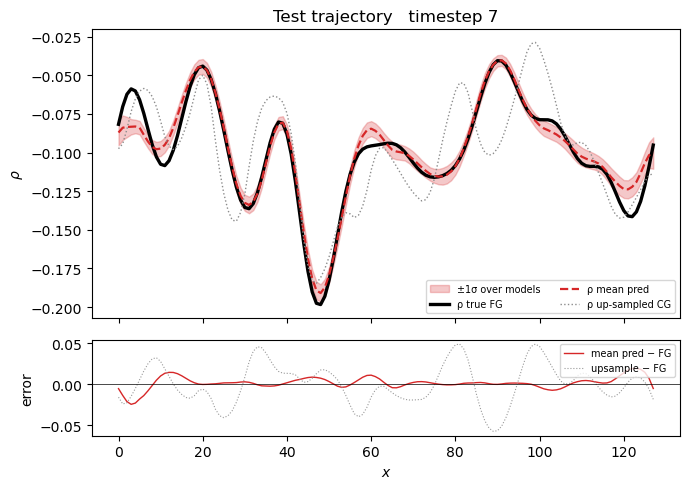

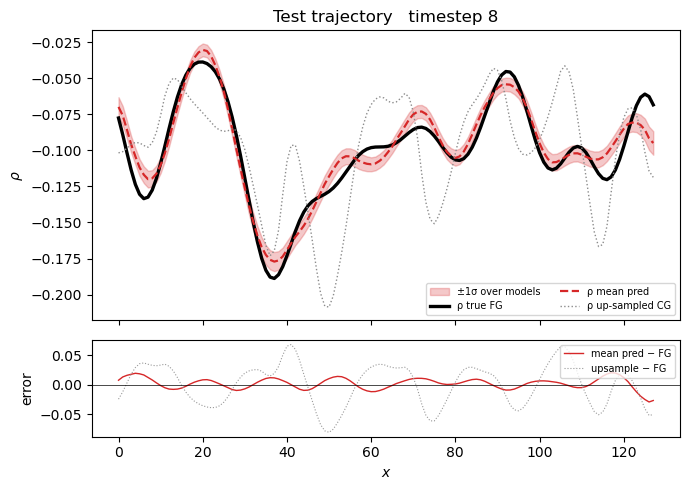

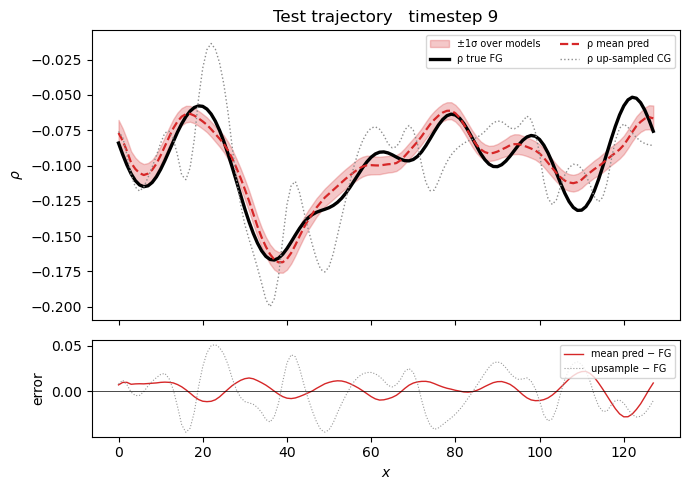

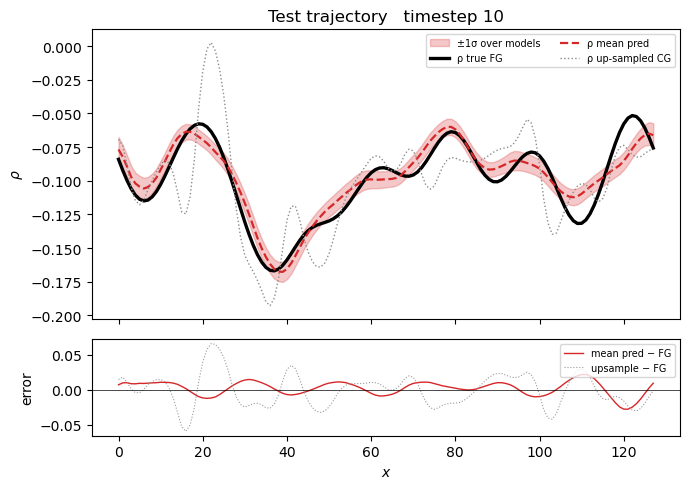

In [17]:
# -------------------------------------------------------------------------
#  PLOT ONE TRAJECTORY / ALL TIME STEPS -----------------------------------
# -------------------------------------------------------------------------
case = 42        # choose any trajectory index
for t in range(Nt):

    # ---- ρ(x) computation ------------------------------------------------
    rho_cg   = qe * input_data [case, t].sum(axis=-1) * dv[Nc]       # (128,)
    rho_up   = zoom(rho_cg, scale_x, order=2)                        # (256,)

    rho_fine = qe * output_data[case, t].sum(axis=-1) * dv[Nf]       # (256,)
    rho_mu   = qe * mean_pred [case, t].sum(axis=-1)  * dv[Nf]       # (256,)
    rho_sig  = qe * std_pred  [case, t].sum(axis=-1)   * dv[Nf]      # (256,)

    # grids
    x_cg, x_fine = np.arange(Nc), np.linspace(0, Nf-1, Nf)

    # ---- main + residual figure -----------------------------------------
    fig, (ax, axr) = plt.subplots(2, 1, figsize=(7, 5),
                                  gridspec_kw=dict(height_ratios=[3, 1]),
                                  sharex=True)

    # top panel ------------------------------------------------------------
    ax.fill_between(x_fine, rho_mu-rho_sig, rho_mu+rho_sig,
                    color='C3', alpha=.25, label='±1σ over models')
    ax.plot(x_fine, rho_fine, color='k',  lw=2.4, label='ρ true FG')
    ax.plot(x_fine, rho_mu,  color='C3', lw=1.6, ls='--', label='ρ mean pred')
    ax.plot(x_fine, rho_up,  color='0.55', ls=':', lw=1, label='ρ up‑sampled CG')
    #ax.plot(x_cg, rho_cg,   color='0.75', lw=.8, marker='o', ms=3,
    #        label='ρ coarse CG')

    ax.set_ylabel(r"$\rho$")
    ax.legend(fontsize=7, ncol=2)
    ax.set_title(f"Test trajectory   timestep {t}")

    # residual panel -------------------------------------------------------
    axr.plot(x_fine, rho_mu - rho_fine,  color='C3', lw=1,
             label='mean pred − FG')
    axr.plot(x_fine, rho_up - rho_fine.cpu().detach().numpy(), color='0.6', ls=':', lw=.8,
             label='upsample − FG')
    axr.axhline(0, color='k', lw=.5)
    axr.set_xlabel(r"$x$")
    axr.set_ylabel("error")
    axr.legend(fontsize=7, loc="upper right")

    plt.tight_layout()
    plt.savefig(f'./figures/new_vlasov/funet_PS_phase1_test_charge_density_ic={case}_t={t}.png')
    plt.show()

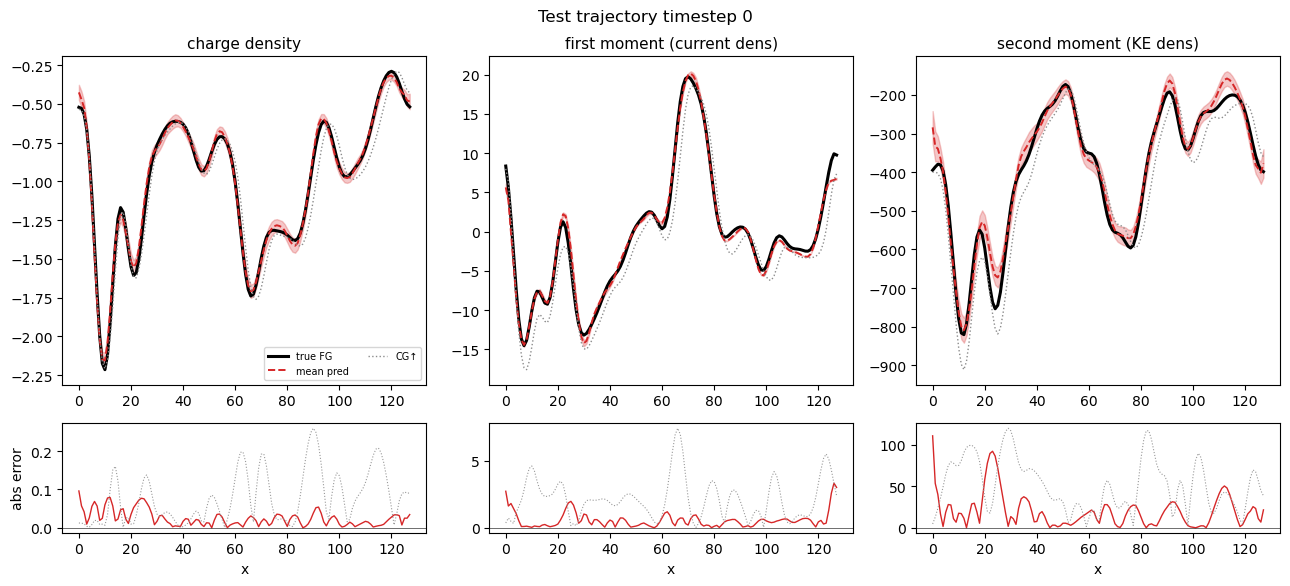

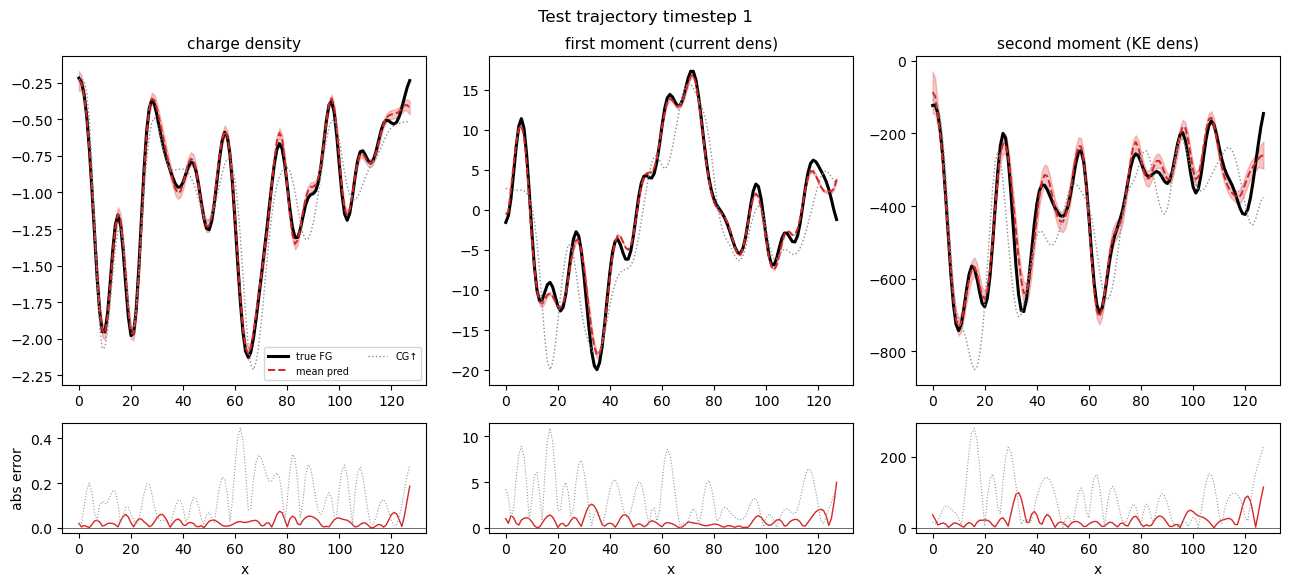

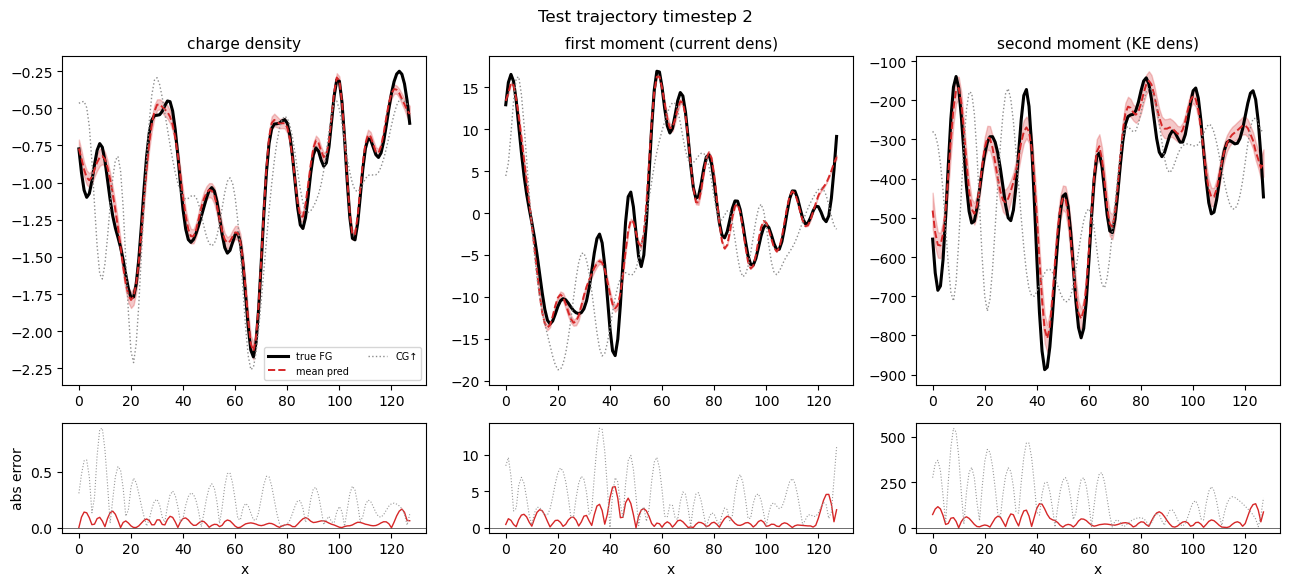

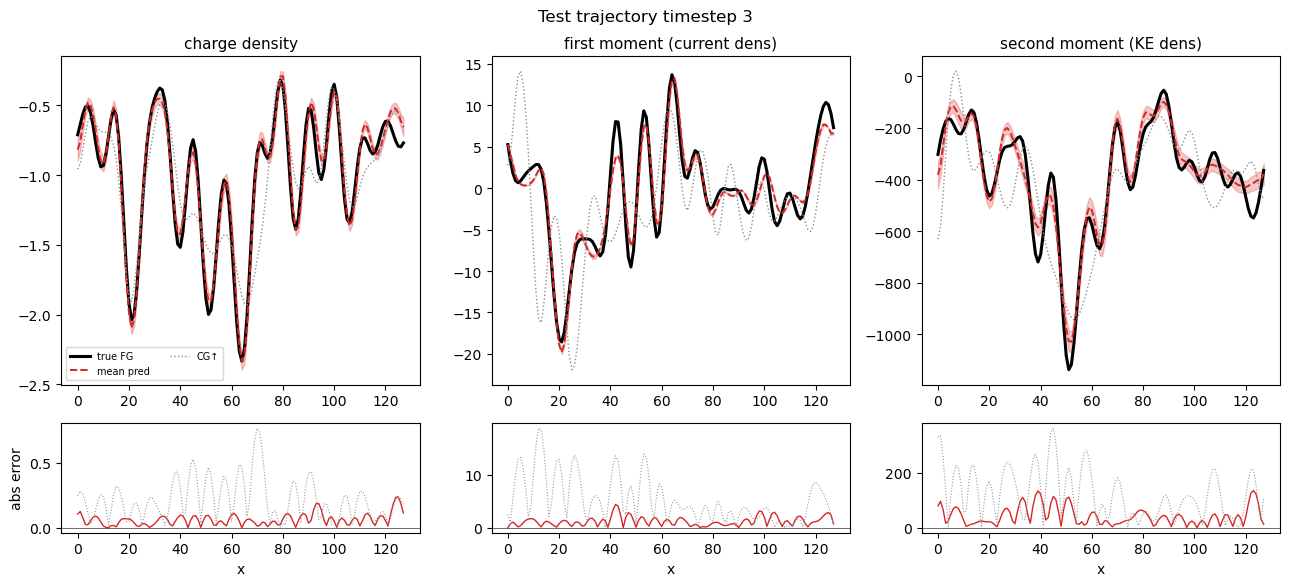

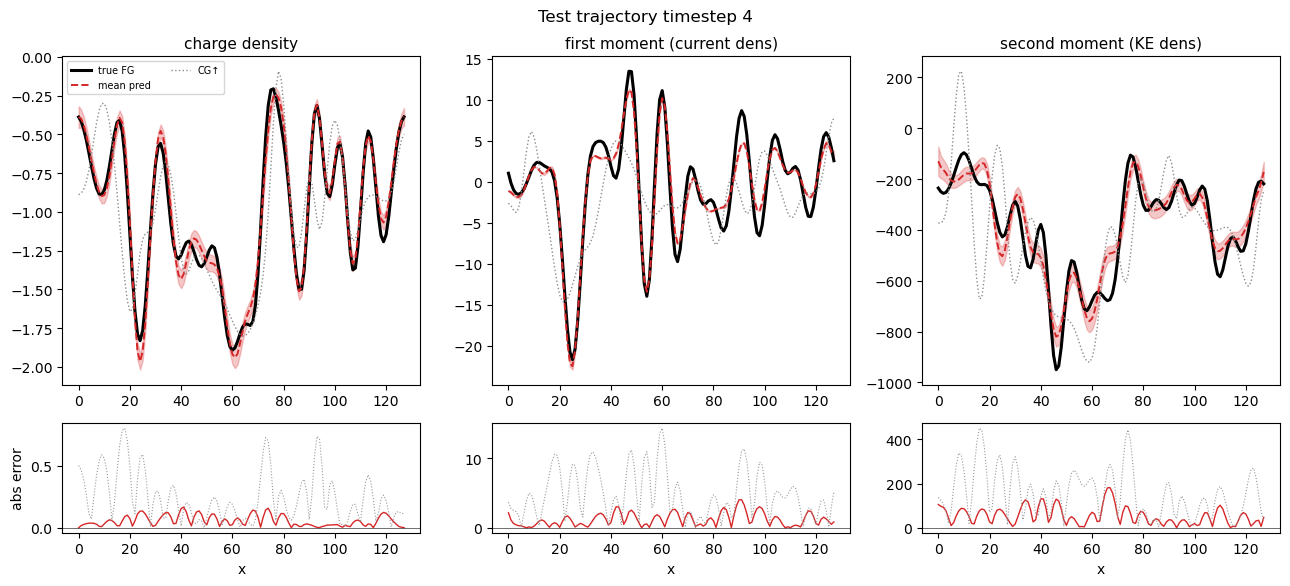

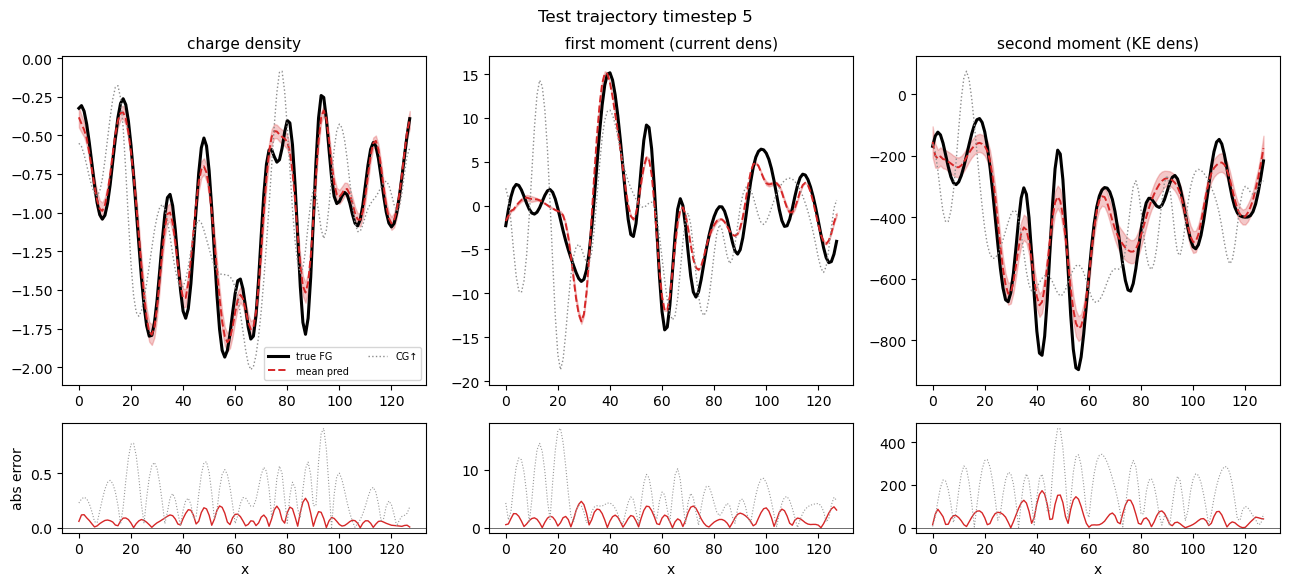

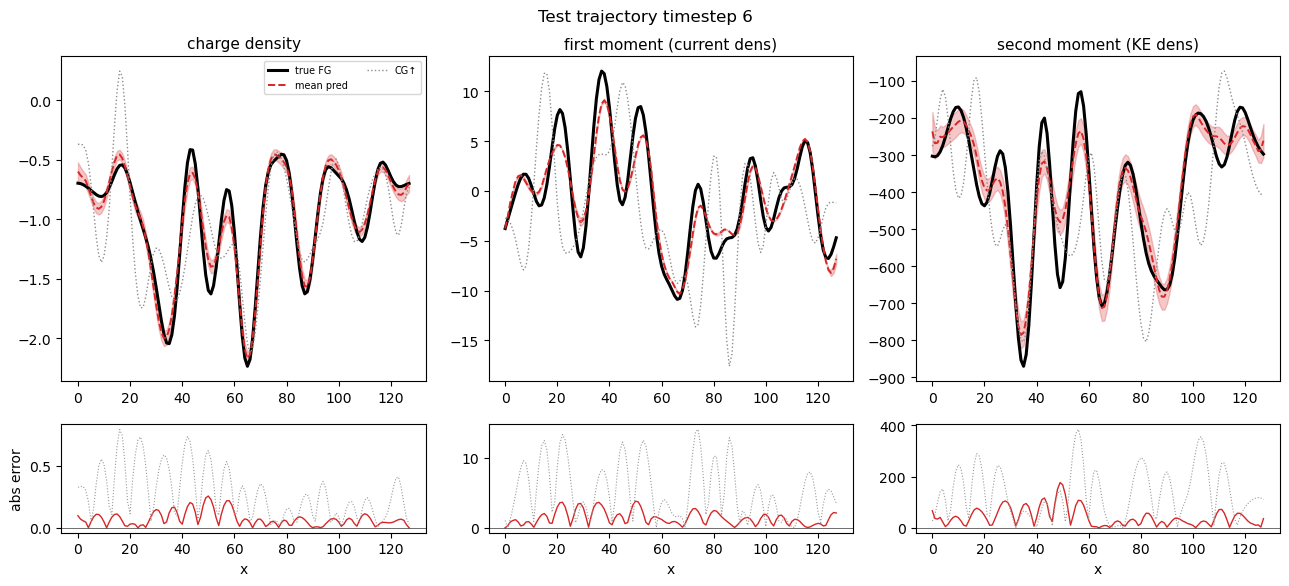

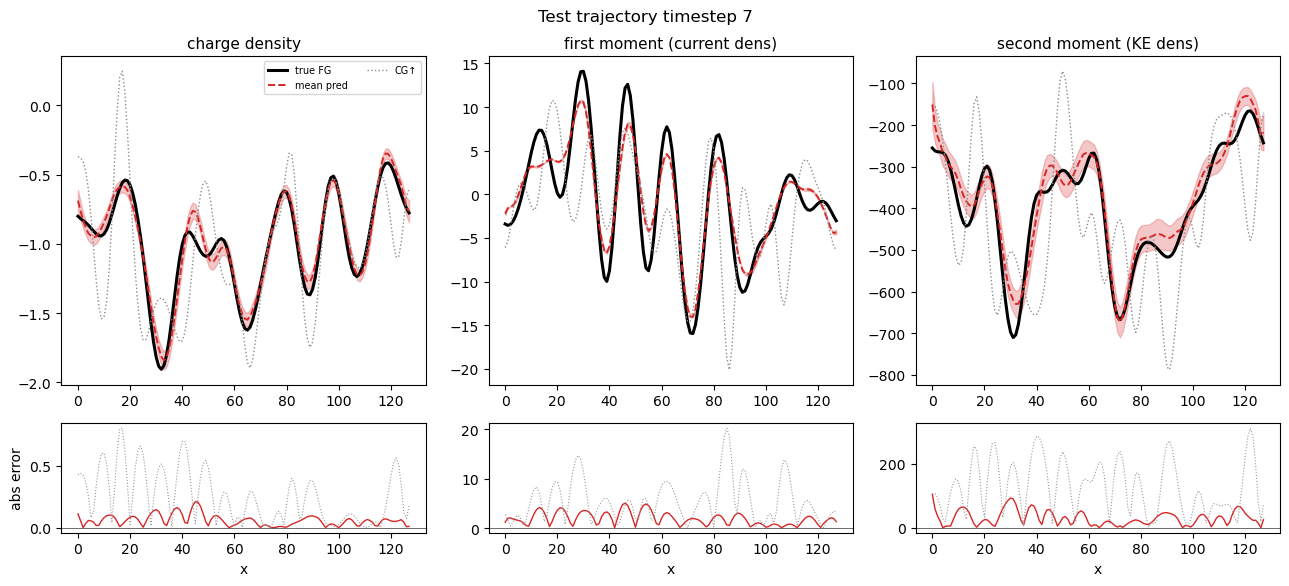

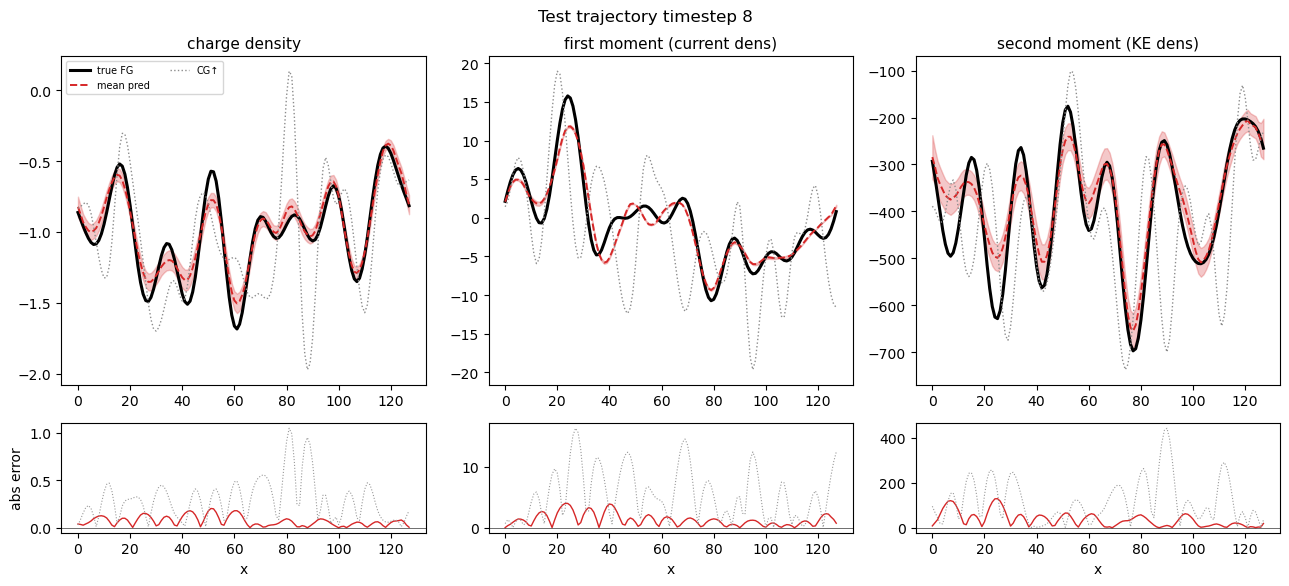

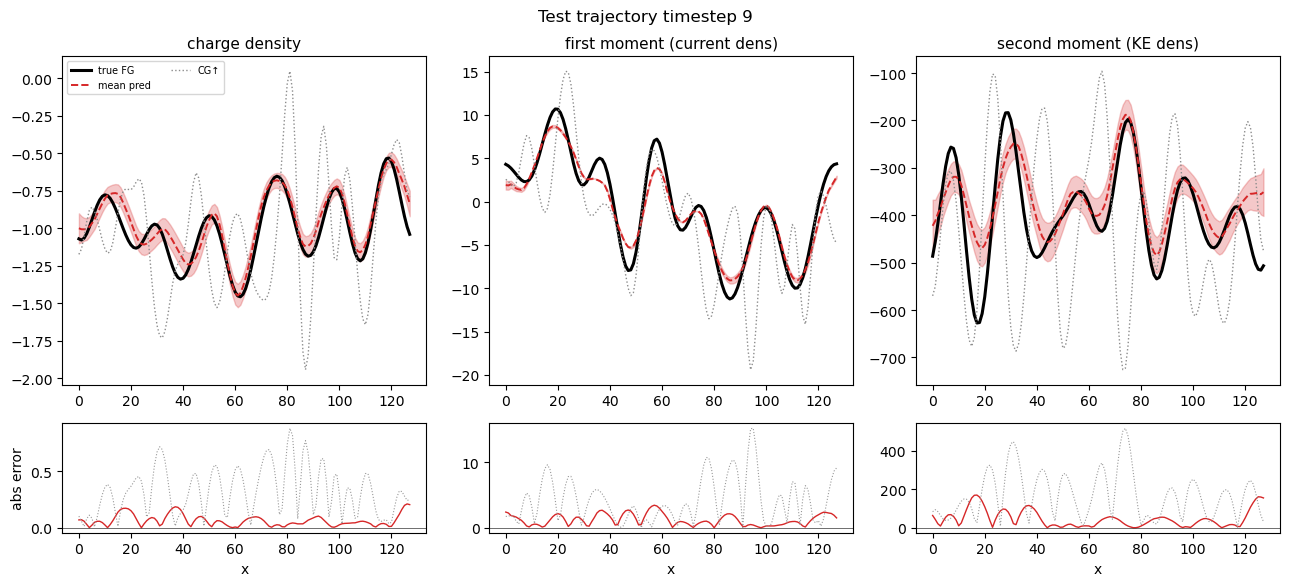

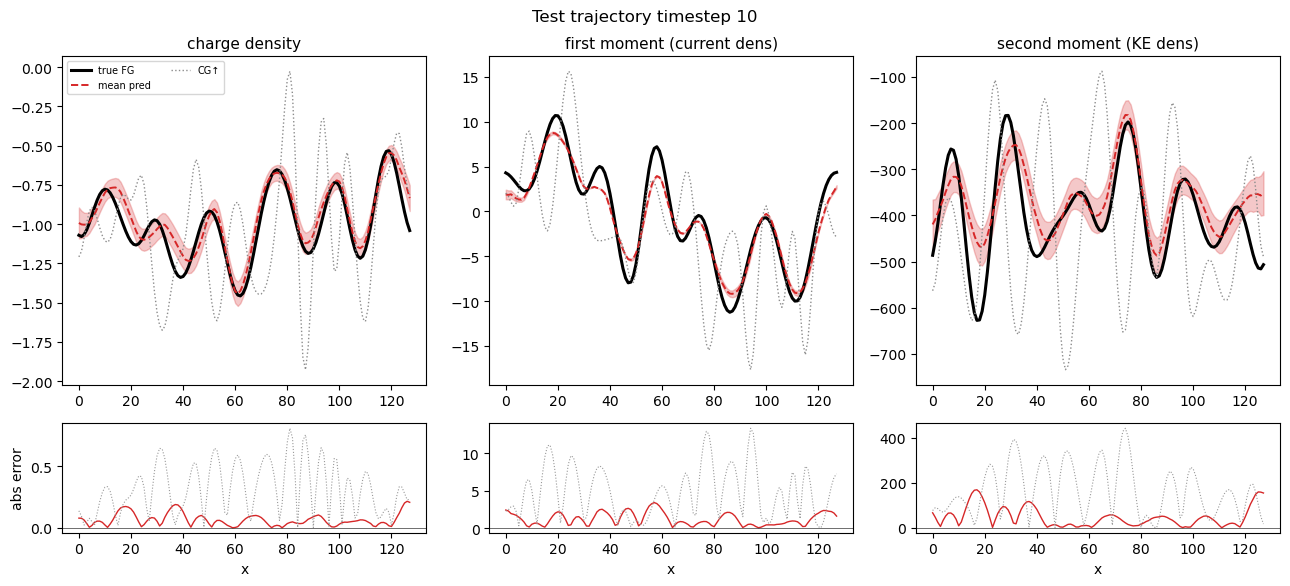


Mean-absolute error over all timesteps:
  Predicted  ρ  : mean = 5.6318e-02,  std = 1.6183e-02
  Predicted  J  : mean = 1.2222e+00,  std = 3.4609e-01
  Predicted  M₂ : mean = 3.9291e+01,  std = 1.0654e+01
  Interp-up  ρ  : mean = 2.4307e-01,  std = 7.3165e-02
  Interp-up  J  : mean = 4.5084e+00,  std = 1.0061e+00
  Interp-up  M₂ : mean = 1.3253e+02,  std = 3.7544e+01

Mean-relative error over all timesteps:
  Predicted  ρ  : mean = 6.5406e-02,  std = 1.8404e-02
  Predicted  J  : mean = 1.4404e+00,  std = 1.4626e+00
  Predicted  M₂ : mean = 1.1525e-01,  std = 3.6548e-02
  Interp-up  ρ  : mean = 2.8788e-01,  std = 8.9006e-02
  Interp-up  J  : mean = 5.6195e+00,  std = 5.6370e+00
  Interp-up  M₂ : mean = 4.2003e-01,  std = 1.3355e-01


In [21]:
from scipy.ndimage import zoom

# -------- helper: velocity-grid moments (Nv = 128 or 256) ---------------
ve_lims = (-60.0, 60.0)
def moments_1d(f_slice, q=-1.0):
    """
    Compute the first three velocity moments of a 1-D phase–space slice.

    Parameters
    ----------
    f_slice : ndarray, shape (Nx, Nv)
        Distribution function evaluated on an (x, v) grid.
    q : float, optional
        Charge (–1 by default).

    Returns
    -------
    rho, J, M2 : ndarray
        Charge density, current density, and kinetic-energy density.
    """
    Nx, Nv = f_slice.shape
    v  = np.linspace(*ve_lims, Nv, endpoint=False)
    dv = v[1] - v[0]
    rho = q * f_slice.sum(-1)       * dv
    J   = q * (f_slice *  v).sum(-1)* dv
    M2  = q * (f_slice * v**2).sum(-1)* dv
    return rho, J, M2
# ------------------------------------------------------------------------

# ----- scale factors and grids ------------------------------------------
scale_x = output_data.shape[2] / input_data.shape[2]   # 2.0
Nx_cg   = input_data.shape[2]
x_cg    = np.arange(Nx_cg)
x_fine  = np.linspace(0, Nf - 1, Nf)

# ----- containers for absolute & relative MAE over time -----------------
err_pr_rho, err_pr_J, err_pr_M2           = [], [], []
rel_pr_rho, rel_pr_J, rel_pr_M2           = [], [], []
err_up_rho, err_up_J, err_up_M2           = [], [], []
rel_up_rho, rel_up_J, rel_up_M2           = [], [], []

eps = 1e-8  # small constant to avoid division by zero

case = 16
for t in range(Nt):

    # ------------- phase-space slices -----------------------------------
    f_cg   = input_data [case, t].numpy()            # coarse grid
    f_up   = zoom(f_cg, scale_x, order=3)            # bicubic up-sample
    f_pred = mean_pred[case, t].numpy()              # model prediction
    f_fine = output_data[case, t].numpy()            # ground-truth FG

    # ------------- moment calculations ----------------------------------
    rho_cg,  J_cg,  M2_cg  = moments_1d(f_cg)
    rho_up,  J_up,  M2_up  = moments_1d(f_up)
    rho_pr,  J_pr,  M2_pr  = moments_1d(f_pred)
    rho_fn,  J_fn,  M2_fn  = moments_1d(f_fine)

    # uncertainty band (std of pred)
    rho_sig, J_sig, M2_sig = moments_1d(std_pred[case, t].numpy())

    # ------------- accumulate per-timestep absolute MAE -----------------
    err_pr_rho.append(np.mean(np.abs(rho_pr - rho_fn)))
    err_pr_J  .append(np.mean(np.abs(J_pr   - J_fn  )))
    err_pr_M2 .append(np.mean(np.abs(M2_pr  - M2_fn )))

    err_up_rho.append(np.mean(np.abs(rho_up - rho_fn)))
    err_up_J  .append(np.mean(np.abs(J_up   - J_fn  )))
    err_up_M2 .append(np.mean(np.abs(M2_up  - M2_fn )))

    # ------------- accumulate per-timestep relative MAE -----------------
    rel_pr_rho.append(np.mean(np.abs(rho_pr - rho_fn) / (np.abs(rho_fn) + eps)))
    rel_pr_J  .append(np.mean(np.abs(J_pr   - J_fn  ) / (np.abs(J_fn  ) + eps)))
    rel_pr_M2 .append(np.mean(np.abs(M2_pr  - M2_fn ) / (np.abs(M2_fn ) + eps)))

    rel_up_rho.append(np.mean(np.abs(rho_up - rho_fn) / (np.abs(rho_fn) + eps)))
    rel_up_J  .append(np.mean(np.abs(J_up   - J_fn  ) / (np.abs(J_fn  ) + eps)))
    rel_up_M2 .append(np.mean(np.abs(M2_up  - M2_fn ) / (np.abs(M2_fn ) + eps)))

    # ------------- plotting (unchanged) ---------------------------------
    fields = [
        (rho_cg, rho_up, rho_pr, rho_fn, rho_sig, "charge density"),
        (J_cg,   J_up,   J_pr,   J_fn,   J_sig,  "first moment (current dens)"),
        (M2_cg,  M2_up,  M2_pr,  M2_fn,  M2_sig, "second moment (KE dens)")
    ]

    fig, axes = plt.subplots(
        2, 3, figsize=(13, 6),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=False, sharey=False
    )

    for col, (cg, up, pr, fn, sig, label) in enumerate(fields):
        ax_top, ax_err = axes[0, col], axes[1, col]

        ax_top.fill_between(x_fine, pr - sig, pr + sig, color='C3', alpha=.25)
        ax_top.plot(x_fine, fn,  'k-',  lw=2.2, label='true FG')
        ax_top.plot(x_fine, pr,  'C3--', lw=1.4, label='mean pred')
        ax_top.plot(x_fine, up,  ':',    color='0.55', lw=1, label='CG↑')
       # ax_top.plot(x_cg,   cg,  '.',    color='0.75', ms=3, label='CG')
        ax_top.set_title(label, fontsize=11)
        if col == 0:
            ax_top.legend(fontsize=7, ncol=2)

        ax_err.plot(x_fine, np.abs(pr - fn), color='C3', lw=1,
                    label='|pred − FG|')
        ax_err.plot(x_fine, np.abs(up - fn), color='0.6', ls=':', lw=.8,
                    label='|CG↑ − FG|')
        ax_err.axhline(0, color='k', lw=.4)
        if col == 0:
            ax_err.set_ylabel("abs error")
        ax_err.set_xlabel("x")

    fig.suptitle(f"Test trajectory timestep {t}", y=0.97)
    plt.tight_layout()
    plt.savefig(f'./figures/new_vlasov/funet_PS_phase1_test_moments_ic={case}_t={t}.png')
    plt.show()

# ---------------------- after the loop finishes --------------------------
err_pr_rho   = np.array(err_pr_rho)
err_pr_J     = np.array(err_pr_J)
err_pr_M2    = np.array(err_pr_M2)
err_up_rho   = np.array(err_up_rho)
err_up_J     = np.array(err_up_J)
err_up_M2    = np.array(err_up_M2)

rel_pr_rho   = np.array(rel_pr_rho)
rel_pr_J     = np.array(rel_pr_J)
rel_pr_M2    = np.array(rel_pr_M2)
rel_up_rho   = np.array(rel_up_rho)
rel_up_J     = np.array(rel_up_J)
rel_up_M2    = np.array(rel_up_M2)

print("\nMean-absolute error over all timesteps:")
print(f"  Predicted  ρ  : mean = {err_pr_rho.mean():.4e},  std = {err_pr_rho.std():.4e}")
print(f"  Predicted  J  : mean = {err_pr_J.mean():.4e},  std = {err_pr_J.std():.4e}")
print(f"  Predicted  M₂ : mean = {err_pr_M2.mean():.4e},  std = {err_pr_M2.std():.4e}")
print(f"  Interp-up  ρ  : mean = {err_up_rho.mean():.4e},  std = {err_up_rho.std():.4e}")
print(f"  Interp-up  J  : mean = {err_up_J.mean():.4e},  std = {err_up_J.std():.4e}")
print(f"  Interp-up  M₂ : mean = {err_up_M2.mean():.4e},  std = {err_up_M2.std():.4e}")

print("\nMean-relative error over all timesteps:")
print(f"  Predicted  ρ  : mean = {rel_pr_rho.mean():.4e},  std = {rel_pr_rho.std():.4e}")
print(f"  Predicted  J  : mean = {rel_pr_J.mean():.4e},  std = {rel_pr_J.std():.4e}")
print(f"  Predicted  M₂ : mean = {rel_pr_M2.mean():.4e},  std = {rel_pr_M2.std():.4e}")
print(f"  Interp-up  ρ  : mean = {rel_up_rho.mean():.4e},  std = {rel_up_rho.std():.4e}")
print(f"  Interp-up  J  : mean = {rel_up_J.mean():.4e},  std = {rel_up_J.std():.4e}")
print(f"  Interp-up  M₂ : mean = {rel_up_M2.mean():.4e},  std = {rel_up_M2.std():.4e}")


In [20]:
eps = 1e-8  # to avoid division by zero

# Assume these are already defined in your namespace:
#   input_data    : torch.Tensor, shape (N_cases, Nt, Nx, Nv)
#   mean_pred     : torch.Tensor, same shape, model mean predictions
#   output_data   : numpy.ndarray, same shape, ground truth
#   moments_1d    : function as defined above
#   scale_x       : float, upsampling factor in x

N_cases    = input_data.shape[0]
N_t        = input_data.shape[1]

# Arrays to store per‐case mean relative errors
case_rel_pr_rho = np.zeros(N_cases)
case_rel_pr_J   = np.zeros(N_cases)
case_rel_pr_M2  = np.zeros(N_cases)
case_rel_up_rho = np.zeros(N_cases)
case_rel_up_J   = np.zeros(N_cases)
case_rel_up_M2  = np.zeros(N_cases)

for case in trange(N_cases):
    rel_pr_rho, rel_pr_J, rel_pr_M2 = [], [], []
    rel_up_rho, rel_up_J, rel_up_M2 = [], [], []

    for t in range(N_t):
        # get the phase‐space slice
        
        f_cg   = input_data[case, t].cpu().numpy()
        f_up   = zoom(f_cg, scale_x, order=3)
        f_pred = mean_pred[case, t].cpu().numpy()
        f_fine = output_data[case, t]

        # compute moments
        rho_up, J_up, M2_up = moments_1d(f_up)
        rho_pr, J_pr, M2_pr = moments_1d(f_pred)
        rho_fn, J_fn, M2_fn = moments_1d(f_fine)

        # accumulate relative MAEs for this timestep
        rel_pr_rho.append(np.mean(np.abs(rho_pr - rho_fn.cpu().detach().numpy()) / (np.abs(rho_fn.cpu().detach().numpy()) + eps)))
        rel_pr_J  .append(np.mean(np.abs(J_pr   - J_fn.cpu().detach().numpy())   / (np.abs(J_fn.cpu().detach().numpy())   + eps)))
        rel_pr_M2 .append(np.mean(np.abs(M2_pr  - M2_fn.cpu().detach().numpy())  / (np.abs(M2_fn.cpu().detach().numpy())  + eps)))

        rel_up_rho.append(np.mean(np.abs(rho_up - rho_fn.cpu().detach().numpy()) / (np.abs(rho_fn.cpu().detach().numpy()) + eps)))
        rel_up_J  .append(np.mean(np.abs(J_up   - J_fn.cpu().detach().numpy())   / (np.abs(J_fn.cpu().detach().numpy())   + eps)))
        rel_up_M2 .append(np.mean(np.abs(M2_up  - M2_fn.cpu().detach().numpy())  / (np.abs(M2_fn.cpu().detach().numpy())  + eps)))

    # mean over timesteps for this case
    case_rel_pr_rho[case] = np.mean(rel_pr_rho)
    case_rel_pr_J[case]   = np.mean(rel_pr_J)
    case_rel_pr_M2[case]  = np.mean(rel_pr_M2)
    case_rel_up_rho[case] = np.mean(rel_up_rho)
    case_rel_up_J[case]   = np.mean(rel_up_J)
    case_rel_up_M2[case]  = np.mean(rel_up_M2)

# now summarize across all cases
print("\nMean-relative error across the full test set (N = %d cases):" % N_cases)
print(f"  Predicted  ρ  : mean = {case_rel_pr_rho.mean():.4e},  std = {case_rel_pr_rho.std():.4e}")
print(f"  Predicted  J  : mean = {case_rel_pr_J.mean():.4e},  std = {case_rel_pr_J.std():.4e}")
print(f"  Predicted  M₂ : mean = {case_rel_pr_M2.mean():.4e},  std = {case_rel_pr_M2.std():.4e}")
print(f"  Interp-up  ρ  : mean = {case_rel_up_rho.mean():.4e},  std = {case_rel_up_rho.std():.4e}")
print(f"  Interp-up  J  : mean = {case_rel_up_J.mean():.4e},  std = {case_rel_up_J.std():.4e}")
print(f"  Interp-up  M₂ : mean = {case_rel_up_M2.mean():.4e},  std = {case_rel_up_M2.std():.4e}")

100%|██████████| 100/100 [00:01<00:00, 53.49it/s]


Mean-relative error across the full test set (N = 100 cases):
  Predicted  ρ  : mean = 7.3075e-02,  std = 1.0141e-02
  Predicted  J  : mean = 3.2424e+00,  std = 1.3625e+01
  Predicted  M₂ : mean = 1.2786e-01,  std = 2.5232e-02
  Interp-up  ρ  : mean = 3.2492e-01,  std = 4.0151e-02
  Interp-up  J  : mean = 1.7972e+01,  std = 1.0969e+02
  Interp-up  M₂ : mean = 4.4454e-01,  std = 1.0739e-01
